# Imports

In [132]:
# Standard library imports
import os
import io
import re
import math
import pickle
import subprocess
from datetime import datetime
from collections import Counter

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import matplotlib.lines as mlines
import matplotlib.image as mpimg
from matplotlib import rc
import seaborn as sns
import missingno as msno
import joblib
import requests
from PIL import Image

from astropy.io import fits
import astropy.units as u
from astropy.cosmology import Planck18

from scipy.stats import gaussian_kde

from sklearn.model_selection import (
    train_test_split,
    cross_validate,
    RandomizedSearchCV,
    GridSearchCV,
    StratifiedKFold
)
from sklearn.metrics import (
    make_scorer,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    matthews_corrcoef,
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score
)
from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler,
    RobustScaler,
    Normalizer
)

from sklearn.experimental import enable_iterative_imputer
from sklearn.cluster import KMeans
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KernelDensity, KNeighborsClassifier

from IPython.display import clear_output

# Local application/library specific imports
from starlight_toolkit.output import read_output_file
import starlight_toolkit.post_processing as pp

pd.set_option("display.max_rows", 300)
pd.set_option("display.max_columns", None)

SEED = 333
np.random.seed(SEED)

dark_mode = True

if dark_mode:
    plt.style.use('dark_background')
    default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    plt.rcParams.update({
        "grid.linewidth": 0.5,
        "grid.alpha": 0.5,
        "legend.facecolor": "#1a1a1a",
        "legend.edgecolor": "white",
        "text.color": 'white',
        "axes.facecolor": "#070207",
        "savefig.facecolor": (0.0, 0.0, 0.0, 0.0)
    })
    bbox = dict(facecolor='#1a1a1a', edgecolor='white', lw=0.5, boxstyle='round,pad=0.2')
    details_colour = 'white'
else:
    plt.style.use('default')
    plt.rcParams.update(plt.rcParamsDefault)

# Starlight toolkit

In [133]:
def plot_spec(out, ax=None, plot_obs=True, plot_syn=True, plot_error=True, plot_labels=True, 
              label_fontsize=12, obs_color='k', syn_color='b', syn_lw=0.6, obs_lw=0.5, w0_color='y', 
              clip_color='m', flag_color='g', syn_label=r'$M_\lambda$', plot_PHO=True, PHO_color='cyan', 
              PHO_label=r'$M_l$', PHO_obs_label=r'$O_l$', wl_range=None, show_legend=False):
    """
    Plots the spectra and photometric information.

    Parameters:
        out (str or dict): Either a Starlight output file name or a dictionary containing the extracted information
                           (output from `starlight_toolkit.output.read_output_file`).
        ax (matplotlib.axes.Axes, optional): The axis on which to plot the data. If None, the current axis is used. Defaults to None.
        plot_obs (bool, optional): Whether to plot the observed spectrum. Defaults to True.
        plot_syn (bool, optional): Whether to plot the synthetic spectrum. Defaults to True.
        plot_error (bool, optional): Whether to plot the error spectrum. Defaults to True.
        plot_labels (bool, optional): Whether to plot axis labels. Defaults to True.
        label_fontsize (int, optional): Fontsize for axis labels. Defaults to 12.
        obs_color (str, optional): Color of the observed spectrum. Defaults to 'k'.
        syn_color (str, optional): Color of the synthetic spectrum. Defaults to 'b'.
        syn_lw (float, optional): Line width of the synthetic spectrum. Defaults to 0.6.
        obs_lw (float, optional): Line width of the observed spectrum. Defaults to 0.5.
        w0_color (str, optional): Color of the spectral points with zero weight. Defaults to 'y'.
        clip_color (str, optional): Color of the clipped spectral points. Defaults to 'm'.
        flag_color (str, optional): Color of the flagged spectral points. Defaults to 'g'.
        syn_label (str, optional): Label for the synthetic spectrum. Defaults to r'$M_lambda$'.
        plot_PHO (bool, optional): Whether to plot photometric data. Defaults to True.
        PHO_color (str, optional): Color of the photometric data. Defaults to 'cyan'.
        PHO_label (str, optional): Label for the photometric data. Defaults to r'$M_l$'.
        PHO_obs_label (str, optional): Label for the observed photometric data. Defaults to r'$O_l$'.
        wl_range (tuple, optional): Spectral range to be ploted, if not specified, full range is plotted. Default is None.
        show_legend (bool, optional): Whether to plot legend. Defaults to False.

    Raises:
        ValueError: If the output file does not contain the expected information.
        IndexError: If the output file format is not as expected.
        Exception: For other unexpected errors while reading the output file.
    """

    if ax is None:
        ax = plt.gca()

    if type(out) is str:
        try:
            out = stout.read_output_file(out)
        except (ValueError, IndexError, Exception):
            print("Check if the output file is ok.")

    l_obs, f_obs, f_syn, f_wei = out['spectra']['l_obs'], \
                                 out['spectra']['f_obs'], out['spectra']['f_syn'], out['spectra']['f_wei']

    w0 = out['spectra']['f_wei'] <= 0

    clipped = out['spectra']['f_wei'] == -1.0

    flagged = out['spectra']['f_wei'] < -1.0

    error = 1 / np.ma.masked_array(f_wei, mask=w0)

    if plot_obs is True:

        f_obs_masked = np.ma.masked_array(data=f_obs, mask=w0)
        f_w0 = np.ma.masked_array(data=f_obs, mask=~w0)
        f_obs_flag = np.ma.masked_array(data=f_obs, mask=~flagged)

        ax.plot(l_obs, f_obs_masked, color=obs_color, lw=obs_lw, label=r'$O_\lambda$')
        ax.plot(l_obs, f_w0, color=w0_color, lw=obs_lw, label=r'$w_\lambda=0$')
        ax.plot(l_obs, f_obs_flag, color=flag_color, lw=obs_lw, label='Flag', zorder=10)

        if clipped.sum() > 0:
            ax.scatter(l_obs, np.ma.masked_array(f_obs, mask=~clipped), color=clip_color,
                       marker='x', label=r'Clipped', zorder=10)

    if plot_error is True:
        ax.plot(l_obs, error, '--r', label=r'$\epsilon_\lambda$', lw=0.5)

    if plot_labels is True:
        ax.set_ylabel(r'$F_\lambda/F_{{\lambda{}}}$'.format(int(out['keywords']['l_norm'])), fontsize=label_fontsize)
        ax.set_xlabel(r'$\lambda\mathrm{[\AA]}$', fontsize=label_fontsize)
    
    if plot_syn is True:
        ax.plot(l_obs, f_syn, color=syn_color, lw=syn_lw, label=syn_label, zorder=5)

    if (out['keywords']['IsPHOcOn'] != 0) & (plot_PHO == True):
        # Reading fluxes and calculating errors
        flux_mod = out['PHO']['fY_mod'] / out['keywords']['fobs_norm']
        flux_obs = out['PHO']['fY_obs'] / out['keywords']['fobs_norm']

        flux_err = flux_obs * out['PHO']['magYErr'] / np.log10(np.e)

        # Reading redshift from output file:
        z = out['keywords']['PHO_Redshift']

        # Getting rest-frame fluxes:
        flux_mod *= (1 + z)
        flux_obs *= (1 + z)

        # Reading wavelengths and shifting them to the rest-frame
        wl_pho = out['PHO']['MeanLamb'] / (1 + z)

        if out['keywords']['IsPHOcOn'] == 1:
            # Plotting observed photometry:
            ax.errorbar(wl_pho, flux_obs, flux_err, fmt='ok', ecolor='k', markersize=4,
                        label=PHO_obs_label)

            # Plotting modeled photometry:
            ax.plot(wl_pho, flux_mod, 'o', color=PHO_color, markersize=4
                    , label=PHO_label, zorder=15)

    ax.set_ylim(0, 1.5 * np.max(f_syn))

    if wl_range is None:
        ax.set_xlim(out['keywords']['l_ini'], out['keywords']['l_fin'])    
    else:
        ax.set_xlim(wl_range[0], wl_range[1])

    if show_legend:
        ax.legend()

    return ax


def plot_spec_simple(out, ax=None, plot_obs=True, plot_syn=True, plot_error=True,
                     plot_labels=True, label_fontsize=12, obs_color='k', syn_color='b', 
                     syn_lw=0.6, obs_lw=0.5, w0_color='y',syn_label=r'$M_\lambda$',
                     plot_PHO=True, PHO_color='cyan', PHO_edgecolor=None,
                     PHO_label=r'$M_l$', PHO_obs_label=r'$O_l$', PHO_markersize=5, 
                     wl_range=None, show_legend=False):
    """
    Simplified plots for Starlight output.

    Parameters:
        out (str or dict): Either a Starlight output file name or a dictionary containing the extracted information
                           (output from `starlight_toolkit.output.read_output_file`).
        ax (matplotlib.axes.Axes, optional): The axis on which to plot the data. If None, the current axis is used. Defaults to None.
        plot_obs (bool, optional): Whether to plot the observed spectrum. Defaults to True.
        plot_syn (bool, optional): Whether to plot the synthetic spectrum. Defaults to True.
        plot_error (bool, optional): Whether to plot the error spectrum. Defaults to True.
        plot_labels (bool, optional): Whether to plot axis labels. Defaults to True.
        label_fontsize (int, optional): Fontsize for axis labels. Defaults to 12.
        obs_color (str, optional): Color of the observed spectrum. Defaults to 'k'.
        syn_color (str, optional): Color of the synthetic spectrum. Defaults to 'b'.
        syn_lw (float, optional): Line width of the synthetic spectrum. Defaults to 0.6.
        obs_lw (float, optional): Line width of the observed spectrum. Defaults to 0.5.
        w0_color (str, optional): Color of the spectral points with zero weight. Defaults to 'y'.
        clip_color (str, optional): Color of the clipped spectral points. Defaults to 'm'.
        syn_label (str, optional): Label for the synthetic spectrum. Defaults to r'$M_lambda$'.
        plot_PHO (bool, optional): Whether to plot photometric data. Defaults to True.
        PHO_color (str, optional): Color of the photometric data. Defaults to 'cyan'.
        PHO_edgecolor (str, optional): Edge color of the photometric markers. If None, defaults to PHO_color. Defaults to None.
        PHO_label (str, optional): Label for the photometric data. Defaults to r'$M_l$'.
        PHO_obs_label (str, optional): Label for the observed photometric data. Defaults to r'$O_l$'.
        PHO_markersize (int, optional): Marker size for photometric data. Defaults to 5.

    Raises:
        ValueError: If the output file does not contain the expected information.
        IndexError: If the output file format is not as expected.
        Exception: For other unexpected errors while reading the output file.
    """
   
    if ax is None:
        ax = plt.gca()

    if PHO_edgecolor is None:
        PHO_edgecolor = PHO_color

    if type(out) is str:
        try:
            out = stout.read_output_file(out)
        except (ValueError, IndexError, Exception):
            print("Check if the output file is ok.")

    l_obs, f_obs, f_syn, f_wei = out['spectra']['l_obs'], \
                                 out['spectra']['f_obs'], out['spectra']['f_syn'], out['spectra']['f_wei']

    w0 = out['spectra']['f_wei'] <= 0

    error = 1 / np.ma.masked_array(f_wei, mask=w0)

    if plot_obs is True:
        f_obs_masked = np.ma.masked_array(data=f_obs, mask=w0)
        f_w0 = np.ma.masked_array(data=f_obs, mask=~w0)

        ax.plot(l_obs, f_obs_masked, color=obs_color, lw=obs_lw, label=r'$O_\lambda$')
        ax.plot(l_obs, f_w0, color=w0_color, lw=obs_lw, label=r'$w_\lambda=0$')

    if plot_error is True:
        ax.plot(l_obs, error, '--r', label=r'$\epsilon_\lambda$', lw=0.5)

    if plot_labels is True:
        ax.set_ylabel(r'$F_\lambda/F_{{\lambda{}}}$'.format(int(out['keywords']['l_norm'])), fontsize=label_fontsize)
        ax.set_xlabel(r'$\lambda\mathrm{[\AA]}$', fontsize=label_fontsize)

    if plot_syn is True:
        ax.plot(l_obs, f_syn, color=syn_color, lw=syn_lw, label=syn_label, zorder=5)

    if (out['keywords']['IsPHOcOn'] != 0) & (plot_PHO == True):
        flux_mod = out['PHO']['fY_mod'] / out['keywords']['fobs_norm']
        flux_obs = out['PHO']['fY_obs'] / out['keywords']['fobs_norm']

        flux_err = flux_obs * out['PHO']['magYErr'] / np.log10(np.e)

        # Reading redshift from output file:
        z = out['keywords']['PHO_Redshift']

        # Getting rest-frame fluxes:
        flux_mod *= (1 + z)
        flux_obs *= (1 + z)

        # Reading wavelengths and shifting them to the rest-frame
        wl_pho = out['PHO']['MeanLamb'] / (1 + z)

        if out['keywords']['IsPHOcOn'] == 1:
            # Plotting observed photometry:
            ax.errorbar(wl_pho, flux_obs, flux_err, fmt='ok', ecolor='k', markersize=PHO_markersize
                        , label=PHO_obs_label, zorder=14)

            # Plotting modeled photometry:
            ax.plot(wl_pho, flux_mod, 'o', color=PHO_color, markersize=PHO_markersize
                    , label=PHO_label, zorder=15, markeredgecolor=PHO_edgecolor, markeredgewidth=1)

    ax.set_ylim(0, 1.5 * np.max(f_syn))
    
    if wl_range is None:
        ax.set_xlim(out['keywords']['l_ini'], out['keywords']['l_fin'])    
    else:
        ax.set_xlim(wl_range[0], wl_range[1])

    if show_legend:
        ax.legend()

    return ax


def plot_filter(filter_file, ax=None, filter_color='k'
                , filter_ls='dashed', redshift=0, scale_factor=1):
    """
    Plots filter transmission curve.

    To plot filters in the observed frame, you should provide the galaxy's redshift,
    which is set to zero as default.

    The variable scale_factor will be multiplied by the filter's transmission.

    Parameters:
        filter_file (str): Path to the file containing filter transmission curve (wavelength, transmission).
        ax (matplotlib.axes.Axes, optional): The axis on which to plot the filter. If None, the current axis is used. Defaults to None.
        filter_color (str, optional): Color of the filter curve. Defaults to 'k'.
        filter_ls (str, optional): Linestyle of the filter curve. Defaults to 'dashed'.
        redshift (float, optional): Redshift of the galaxy. Defaults to 0.
        scale_factor (float, optional): Scaling factor for the filter's transmission. Defaults to 1.
    """
    
    if ax is None:
        ax = plt.gca()

    # Reading filter:
    wl_filter, T_filter = np.genfromtxt(filter_file).transpose()

    # Plotting:
    ax.plot(wl_filter / (1 + redshift), T_filter * scale_factor, color=filter_color
            , linestyle=filter_ls)


def plot_residual_spec(out, ax=None, residual_color='g'
                       , plot_labels=True):
    """
    Plots the residual spectrum.

    Parameters:
        out (dict): Dictionary containing Starlight output data.
        ax (matplotlib.axes.Axes, optional): The axis on which to plot the residual spectrum. If None, the current axis is used. Defaults to None.
        residual_color (str, optional): Color of the residual spectrum curve. Defaults to 'g'.
        plot_labels (bool, optional): Whether to plot axis labels. Defaults to True.
    """
    
    if ax is None:
        ax = plt.gca()

    l_obs, f_obs, f_syn, f_wei = out['spectra']['l_obs'], \
                                 out['spectra']['f_obs'], out['spectra']['f_syn'], out['spectra']['f_wei']

    w0 = out['spectra']['f_wei'] <= -1

    residual = np.ma.masked_array(data=(f_obs - f_syn) / f_syn, mask=w0)

    ax.plot(l_obs, residual, lw=0.3, color=residual_color)

    x = np.linspace(l_obs[0], l_obs[-1])
    y = np.zeros_like(x)

    ax.plot(x, y, '--k')

    if plot_labels is True:
        ax.set_xlabel(r'$\lambda[\mathrm{\AA}]$', fontsize=10)
        ax.set_ylabel(r'Residual', fontsize=10)


def plot_sfh(out, ax=None, plot_axlabels=True, x_color='b', m_color='r'):
    """
    Plots Starlight star-formation histories.

    Parameters:
        out (dict): Dictionary containing the output data.
        ax (matplotlib.axes.Axes, optional): The axis on which to plot the SFH. If None, the current axis is used. Defaults to None.
        plot_axlabels (bool, optional): Whether to plot axis labels. Defaults to True.
    """

    if ax is None:
        ax = ax.gca()

    if type(out) is str:
        try:
            out = stout.read_output_file(out)
        except (ValueError, IndexError, Exception):
            print("Check if the output file is ok.")

    age_base = out['population']['popage_base']
    popx = out['population']['popx']
    popmu_ini = out['population']['popmu_ini']

    agevec, sfh_x, csfh_x = pp.calc_sfh_x(age_base, popx)
    agevec, sfh_m, csfh_mu = pp.calc_sfh(age_base, popmu_ini)

    ax.plot(np.log10(agevec), csfh_x, color=x_color, label=r'$x$')
    ax.scatter(np.log10(agevec), csfh_x, color=x_color, edgecolors='w')

    ax.plot(np.log10(agevec), csfh_mu, color=m_color, label=r'$\mu$')
    ax.scatter(np.log10(agevec), csfh_mu, color=m_color, edgecolors='w')

    if out['keywords']['IsQHRcOn'] == 1:
        popQHR = out['popQHR']['QHeff_Perc']
        cQHRvec = pp.calc_QHRpop_x(age_base, popQHR)
        ax.plot(np.log10(agevec), cQHRvec, color='m', label=r'$Q_H$')
        ax.plot(np.log10(agevec), cQHRvec, '.m')

    if plot_axlabels is True:
        ax.set_xlabel(r'$\log \; t_* \; \mathrm{[yr]}$', fontsize=10)
        ax.set_ylabel('Cumulative Fraction [%]', fontsize=10)


def plot_fit_complete(out, title=None, figsize=(7.75, 6.5), out_fig_fname=None, out_dpi=None, legend_loc='best',
                      wl_range=None):
    """
    Plots a complete diagnostic of the fit including spectrum, residual spectrum, star formation history
    and best-fit parameters.

    Parameters:
        out (dict or str): Dictionary containing the output data or path to the output file.
        title (str, optional): Title of the plot. Defaults to None.
        figsize (tuple, optional): Figure size in inches. Defaults to (7.75, 6.5).
        out_fig_fname (str, optional): File name to save the figure. Defaults to None (not saved).
        out_dpi (int, optional): Dots per inch for saving the figure. Defaults to None.
        legend_loc (str, optional): Location of the legend. Defaults to 'best'.
        wl_range (tuple, optional): Wavelength range to plot. Defaults to None.
        
    Returns:
        matplotlib.axes.Axes: Axes for spectrum.
        matplotlib.axes.Axes: Axes for residual spectrum.
        matplotlib.axes.Axes: Axes for star formation history.
        matplotlib.axes.Axes: Axes for annotations.
    """

    if type(out) is str:
        try:
            out = stout.read_output_file(out)
        except (ValueError, IndexError, Exception):
            print("Check if the output file is ok.")

    fig = plt.figure(figsize=figsize)

    # Plot spectrum:
    gs1 = gridspec.GridSpec(3, 3)
    gs1.update(bottom=0.47, top=0.96, hspace=0.05, right=0.96)

    gs2 = gridspec.GridSpec(1, 3)
    gs2.update(top=0.38, bottom=0.08, hspace=0.05, right=0.96, wspace=0.02)

    p1 = plt.subplot(gs1[0:2, :])
    p2 = plt.subplot(gs1[2, :], sharex=p1)
    p3 = plt.subplot(gs2[0, 0])
    p4 = plt.subplot(gs2[0, 1:3])

    plot_spec(out, ax=p1, plot_labels=False)
    p1.set_ylabel(fr'$F_\lambda/F_{{\lambda({out["keywords"]["l_norm"]})}}$', fontsize=11)

    p1.axes.xaxis.set_visible(False)
    p1.set_ylim(0, 2.25)

    if wl_range is not None:
        p1.set_xlim(wl_range[0], wl_range[1])

    if title is None:
        p1.set_title(out['keywords']['arq_synt'])
    else:
        p1.set_title(title)

    # Create legend:
    p1.legend(frameon=False, fontsize=9, ncol=2, loc=legend_loc)

    # Plot residual spectrum:
    plot_residual_spec(out, ax=p2)

    p2.set_ylim(-0.15, 0.15)

    # Plotting SFH:

    plot_sfh(out, p3)

    p3.set_xticks([6, 7, 8, 9, 10])

    p3.legend(frameon=False, fontsize=9)

    p3.set_ylim(0, 110)
    p3.set_xlim(5.8, 11)

    # Removing ticks:
    p4.set_xticks([])
    p4.set_yticks([])

    # # Calculating mass- and light-weighted ages:
    if 'popage_base_upp' in out['population'].keys():

        age_base = out['population']['popage_base']
        age_base_upp = out['population']['popage_base_upp']
        Z_base = out['population']['popZ_base']
        popx = out['population']['popx']
        popmu_cor = out['population']['popmu_cor']

        atflux = pp.calc_atflux(age_base, popx, age_base_upp)
        atmass = pp.calc_atmass(age_base, popmu_cor, age_base_upp)
        Zflux = pp.calc_aZflux(Z_base, popx, 0.02)
        Zmass = pp.calc_aZmass(Z_base, popmu_cor, 0.02)

    else:

        age_base = out['population']['popage_base']
        Z_base = out['population']['popZ_base']
        popx = out['population']['popx']
        popmu_cor = out['population']['popmu_cor']

        atflux = pp.calc_atflux(age_base=age_base, popx=popx)
        atmass = pp.calc_atmass(age_base=age_base, popmu=popmu_cor)
        Zflux = pp.calc_aZflux(Z_base, popx, 0.02)
        Zmass = pp.calc_aZmass(Z_base, popmu_cor, 0.02)

    # Annotating stuff:
    annotation_size = 9

    p4.grid(False)

    p4.annotate(r'$\log M_*=$ %0.2f' % np.log10(out['keywords']['Mcor_tot']),
                (0.02, 0.025), size=annotation_size)
    p4.annotate(r'$\sigma_*$=%0.2f' % out['keywords']['vd'],
                (0.02, 0.15), size=annotation_size)
    p4.annotate(r'$N_{\mathrm{Clipped}}$=%i' % out['keywords']['Ntot_clipped'],
                (0.02, 0.3), size=annotation_size)
    p4.annotate(r'$\chi^2/N_{eff}$=%0.2f' % out['keywords']['chi2/N_eff'],
                (0.02, 0.45), size=annotation_size)
    try:
        p4.annotate(r'$\chi^2_{\mathrm{OPT}}$=%0.2f' % out['keywords']['chi2_OPT'],
                    (0.02, 0.6), size=annotation_size)
    except:
        pass
    p4.annotate(r'$\chi^2_{\mathrm{TOT}}$=%0.2f' % out['keywords']['chi2'],
                (0.02, 0.75), size=annotation_size)
    p4.annotate(r'$\overline{\Delta}$=%0.2f%%' % out['keywords']['adev'],
                (0.02, 0.9), size=annotation_size)

    p4.annotate(r'$A_V^Y$ = %0.2f' % (out['keywords']['AV'] + out['keywords']['exAV']),
                (0.27, 0.025), size=annotation_size)
    p4.annotate(r'$A_V$ = %0.2f' % out['keywords']['AV'],
                (0.27, 0.15), size=annotation_size)
    p4.annotate(r'$S/N=$ %0.2f' % out['keywords']['SN_snwin'],
                (0.27, 0.3), size=annotation_size)
    p4.annotate(r'$\langle \log Z_{*} \rangle_M=$%0.2f' % Zmass,
                (0.27, 0.45), size=annotation_size)
    p4.annotate(r'$\langle \log Z_{*} \rangle_L=$%0.2f' % Zflux,
                (0.27, 0.6), size=annotation_size)
    p4.annotate(r'$\langle \log t_{*} \rangle_M=$%0.2f' % atmass,
                (0.27, 0.75), size=annotation_size)
    p4.annotate(r'$\langle \log t_{*} \rangle_L=$%0.2f' % atflux,
                (0.27, 0.9), size=annotation_size)

    p4.annotate('ESM=%s' % out['keywords']['ETC_ESM'],
                (0.51, 0.9), size=annotation_size)

    if out['keywords']['IsPHOcOn'] == 1:
        p4.annotate(r'$\chi^2_{PHO}=%0.2f, k_{PHO}=%0.2f$'\
                    % (out['keywords']['chi2_PHO'], out['keywords']['k_PHO']),
                    (0.51, 0.45), size=annotation_size)
    if out['keywords']['IsPHOcOn'] == -1:
        p4.annotate('Predicting PHO', (0.51, 0.45), size=annotation_size)
    if out['keywords']['IsPHOcOn'] == 0:
        p4.annotate('PHO off', (0.51, 0.45), size=annotation_size)

    if out['keywords']['IsELROn'] == 0:
        p4.annotate(r'$x(A_V^Y) = {} \%$'.format(out['keywords']['x(exAV>0)']),
                    (0.51, 0.3), size=annotation_size)

    if out['keywords']['IsQHRcOn'] == 1:
        p4.annotate(r'$\chi^2_{QHR}=%0.2f, k_{QHR}=%0.2f$'\
                    % (out['keywords']['chi2_QHR'], out['keywords']['k_QHR']),
                    (0.51, 0.6), size=annotation_size)
        if out['keywords']['IsELROn'] == 1:
            exHalpha = np.sum(out['popQHR']['Y_Perc_Line0'][out['population']['popexAV_flag'] == 1])
            epsilonQ = out['ELR']['Err_logR'] / np.sqrt(out['keywords']['k_QHR'])

            p4.annotate(r'$x(A_V^Y) = {} \%, x(A_V^Y)H_\alpha$ = {} %'.format(out['keywords']['x(exAV>0)'], exHalpha),
                        (0.51, 0.15), size=annotation_size)

            p4.annotate(r'$AV_{neb}=%0.2f$' \
                        % (out['keywords']['AV_neb']), (0.51, 0.025), size=annotation_size)

            p4.annotate(r'$\Delta\logR=%0.3f, \epsilon^{eff}_R=%1.2e$' \
                        % (out['ELR']['logR_obs'] - out['ELR']['logR_mod'], epsilonQ),
                        (0.51, 0.3), size=annotation_size)

        if out['keywords']['IsELROn'] == -1:
            p4.annotate('Predicting ELR', (0.51, 0.3), size=annotation_size)
        if out['keywords']['IsELROn'] == 0:
            p4.annotate('ELR off', (0.51, 0.3), size=annotation_size)
    
    if out['keywords']['IsQHRcOn'] == -1:
        p4.annotate('Predicting QHR', (0.51, 0.6), size=annotation_size)
    if out['keywords']['IsQHRcOn'] == 0:
        p4.annotate('QHRc off', (0.51, 0.6), size=annotation_size)

    if out['keywords']['IsFIRcOn'] == 1:
        p4.annotate(r'$\chi^2_{FIR}=%0.2f, k^2_{FIR}=%0.2f$' \
                    % (out['keywords']['chi2_FIR'], out['keywords']['k_FIR']), \
                    (0.51, 0.75), size=annotation_size)
    if out['keywords']['IsFIRcOn'] == -1:
        p4.annotate(r'$\log L_{FIR}^{mod}=%0.2f, FIR/BOL=%0.2f$' \
                    % (out['keywords']['FIR_logLFIR_mod'], out['keywords']['FIR_BOL_Ratio'])
                    , (0.51, 0.75), size=annotation_size)
    if out['keywords']['IsFIRcOn'] == 0:
        p4.annotate('FIRc off', (0.51, 0.75), size=annotation_size)

    if out_fig_fname is not None:
        plt.savefig(out_fig_fname, dpi=out_dpi)
        plt.close()

    return p1, p2, p3, p4


def convert_x_lambda(popx, wl, wl_0, base_wl, base_f):
    """
    Convert the stellar population vector a different normalization wavelength.

    Parameters:
        popx (ndarray): Stellar population vector.
        wl (float): Target wavelength.
        wl_0 (float): Reference wavelength.
        base_wl (ndarray): Base wavelength array.
        base_f (ndarray): Base flux array.

    Returns:
        ndarray: Population vector normalized at target wavelength.
    """

    base_wl_res = np.arange(np.round(base_wl[0]), np.round(base_wl[-1]), 1)
    base_f_res  = np.array([resampler(base_wl, base_f[i], base_wl_res) for i in range(len(base_f))])
    
    base_f_norm = [base_f_res[i][base_wl_res==wl]/base_f_res[i][base_wl_res==wl_0]  for i in range(len(base_f))]
    base_f_norm = np.array([base_f_norm[i][0]  for i in range(len(base_f))])

    popx_wl = np.array([popx[i]*base_f_norm/np.sum(popx[i]*base_f_norm) for i in range(len(popx))])
    
    return popx_wl


def calc_sfh(age_base, popmu):
    """
    Calculates the star formation history (SFH) and cumulative SFH.

    Parameters:
        age_base (ndarray): Array of stellar population ages.
        popmu (ndarray): Population mass fractions.

    Returns:
       tuple: A tuple containing three elements: agevec (ndarray) - unique ages, sfh (ndarray) - SFH,
        and csfh (ndarray) - cumulative SFH.
    """
 
    agevec = np.unique(age_base)
 
    sfh = [np.sum(popmu[age_base==agevec[i]]) for i in range(len(agevec))]
    sfh /= popmu.sum() 
    sfh *= 100
 
    csfh = np.cumsum(sfh[::-1])
 
    return agevec, sfh, csfh[::-1]


def calc_sfh_x(age_base, popx):
    """
    Calculates the star formation history (SFH) and cumulative SFH for stellar population fractions.

    Parameters:
        age_base (ndarray): Array of stellar population ages.
        popx (ndarray): Stellar population light fractions.

    Returns:
        tuple: A tuple containing three elements: agevec (ndarray) - unique ages, sfh (ndarray) - SFH,
        and csfh (ndarray) - cumulative SFH.
    """
 
    agevec = np.unique(age_base)

    sfh = [np.sum(popx[age_base==agevec[i]]) for i in range(len(agevec))]
    sfh /= popx.sum() 
    sfh *= 100

    csfh = np.cumsum(sfh[::-1])

    return agevec, sfh, csfh[::-1]


def calc_atflux(age_base, popx, age_base_upp=None):
    """
    Calculates the luminosity-weighted age based on population fractions.

    Parameters:
        age_base (ndarray): Array of stellar population ages.
        popx (ndarray): Stellar population light fractions.
        age_base_upp (ndarray, optional): Upper age limits for each age bin. Defaults to None.

    Notes:
        If `age_base_upp` is given, the average is calculated based on the central age of the bins.

    Returns:
        float: Luminosity-weighted age of the object.
    """

    if age_base_upp is not None:
        log_t1 = np.log10(age_base)
        log_t2 = np.log10(age_base_upp)
        log_t = (log_t1 + log_t2) / 2.0
    else:
        log_t = np.log10(age_base)
    return np.sum(log_t * popx) / popx.sum()


def calc_atmass(age_base, popmu, age_base_upp=None):
    """
    Calculates the mass-weighted age based on population fractions.

    Parameters:
        age_base (ndarray): Array of stellar population ages.
        popx (ndarray): Stellar population mass fractions.
        age_base_upp (ndarray, optional): Upper age limits for each age bin. Defaults to None.

    Notes:
        If `age_base_upp` is given, the average is calculated based on the central age of the bins.

    Returns:
        float: Mass-weighted age of the object.
    """

    if age_base_upp is not None:
        log_t1 = np.log10(age_base)
        log_t2 = np.log10(age_base_upp)
        log_t  = (log_t1 + log_t2) / 2.0
    else:
        log_t  = np.log10(age_base)        
    return np.sum(log_t * popmu) / popmu.sum()

   
def calc_aZflux(Z_base, popx, Z_sun): 
    """
    Calculates the luminosity-weighted metallicity based on population fractions.

    Parameters:
        Z_base (ndarray): Array of metallicities for the stellar populations.
        popx (ndarray): Stellar population fractions.
        Z_sun (float): Solar metallicity value.

    Returns:
        float: Luminosity-weighted metallicity.
    """

    return (popx * np.log10(Z_base/Z_sun)).sum()/popx.sum()


def calc_aZmass(Z_base, popmu, Z_sun): 
    """
    Calculates the mass-weighted metallicity based on population fractions.

    Parameters:
        Z_base (ndarray): Array of metallicities for the stellar populations.
        popx (ndarray): Stellar population fractions.
        Z_sun (float): Solar metallicity value.

    Returns:
        float: Mass-weighted metallicity.
    """

    return (popmu * np.log10(Z_base/Z_sun)).sum()/popmu.sum()


def plot_fit_complete_dark(out, title=None, figsize=(12, 8), out_fig_fname=None, out_dpi=150, 
                      legend_loc='upper right', wl_range=None, style='dark'):
    """
    Plots a complete diagnostic of the fit including spectrum, residual spectrum, star formation history
    and best-fit parameters with improved aesthetics.

    Parameters:
        out (dict or str): Dictionary containing the output data or path to the output file.
        title (str, optional): Title of the plot. Defaults to None.
        figsize (tuple, optional): Figure size in inches. Defaults to (12, 8).
        out_fig_fname (str, optional): File name to save the figure. Defaults to None (not saved).
        out_dpi (int, optional): Dots per inch for saving the figure. Defaults to 150.
        legend_loc (str, optional): Location of the legend. Defaults to 'upper right'.
        wl_range (tuple, optional): Wavelength range to plot. Defaults to None.
        style (str, optional): Plot style ('dark', 'modern' or 'classic'). Defaults to 'dark'.
        
    Returns:
        matplotlib.axes.Axes: Axes for spectrum.
        matplotlib.axes.Axes: Axes for residual spectrum.
        matplotlib.axes.Axes: Axes for star formation history.
        matplotlib.axes.Axes: Axes for annotations.
    """

    if type(out) is str:
        try:
            out = read_output_file(out)
        except (ValueError, IndexError, Exception):
            print("Check if the output file is ok.")
            return None

    # Configurar estilo
    if style == 'dark':
        plt.style.use('dark_background')
        colors = {
            'obs': '#FF6B6B',        # Coral vibrante
            'syn': '#4ECDC4',        # Turquesa 
            'residual': '#FFE66D',   # Amarelo suave
            'sfh_x': '#95E1D3',      # Verde menta
            'sfh_mu': '#F38BA8',     # Rosa suave
            'background': '#1A1A1A', # Cinza escuro
            'text': '#FFFFFF',       # Branco
            'grid': '#404040'        # Cinza médio
        }
    elif style == 'modern':
        plt.style.use('seaborn-v0_8-whitegrid')
        colors = {
            'obs': '#2E3440',
            'syn': '#5E81AC', 
            'residual': '#BF616A',
            'sfh_x': '#A3BE8C',
            'sfh_mu': '#D08770',
            'background': '#ECEFF4',
            'text': '#2E3440',
            'grid': '#E5E5E5'
        }
    else:
        colors = {
            'obs': 'black',
            'syn': 'blue',
            'residual': 'green',
            'sfh_x': 'blue',
            'sfh_mu': 'red',
            'background': 'white',
            'text': 'black',
            'grid': '#CCCCCC'
        }

    fig = plt.figure(figsize=figsize, facecolor=colors['background'])
    fig.patch.set_facecolor(colors['background'])

    # Layout melhorado com GridSpec
    gs = gridspec.GridSpec(3, 4, hspace=0.3, wspace=0.3, 
                          left=0.08, right=0.95, top=0.93, bottom=0.08)
    
    # Painel principal do espectro (maior)
    p1 = plt.subplot(gs[0:2, 0:3])
    
    # Painel dos resíduos (compartilha x com p1)
    p2 = plt.subplot(gs[2, 0:3], sharex=p1)
    
    # Painel da história de formação estelar
    p3 = plt.subplot(gs[0:2, 3])
    
    # Painel de anotações/parâmetros
    p4 = plt.subplot(gs[2, 3])

    # Configurar cores de fundo dos painéis
    for ax in [p1, p2, p3]:
        ax.set_facecolor(colors['background'])
        
    # Plot do espectro principal
    plot_spec(out, ax=p1, plot_labels=False, obs_color=colors['obs'], 
              syn_color=colors['syn'], show_legend=False)
    
    # Melhorar aparência do espectro
    p1.set_ylabel(fr'$F_\lambda/F_{{\lambda({out["keywords"]["l_norm"]})}}$', 
                  fontsize=12, fontweight='bold', color=colors['text'])
    p1.tick_params(axis='both', which='major', labelsize=10, colors=colors['text'])
    p1.grid(True, alpha=0.3, linestyle='--', color=colors['grid'])
    p1.set_ylim(0, 1.8 * np.max(out['spectra']['f_syn']))

    if wl_range is not None:
        p1.set_xlim(wl_range[0], wl_range[1])

    if title is None:
        p1.set_title(out['keywords']['arq_synt'], fontsize=14, fontweight='bold', 
                    pad=20, color=colors['text'])
    else:
        p1.set_title(title, fontsize=14, fontweight='bold', pad=20, color=colors['text'])

    # Legenda melhorada com estilo escuro
    legend_elements = [
        mlines.Line2D([0], [0], color=colors['obs'], lw=2, label=r'Observado ($O_\lambda$)'),
        mlines.Line2D([0], [0], color=colors['syn'], lw=2, label=r'Modelo ($M_\lambda$)')
    ]
    
    if style == 'dark':
        legend = p1.legend(handles=legend_elements, loc=legend_loc, frameon=True, 
                          fancybox=True, shadow=True, fontsize=10,
                          facecolor='#2A2A2A', edgecolor=colors['text'], 
                          labelcolor=colors['text'])
        legend.get_frame().set_alpha(0.9)
    else:
        p1.legend(handles=legend_elements, loc=legend_loc, frameon=True, 
                  fancybox=True, shadow=True, fontsize=10)

    # Plot dos resíduos melhorado
    plot_residual_spec(out, ax=p2, residual_color=colors['residual'])
    p2.set_ylim(-0.2, 0.2)
    p2.set_xlabel(r'Comprimento de Onda $\lambda$ [Å]', fontsize=12, 
                  fontweight='bold', color=colors['text'])
    p2.set_ylabel('Resíduo', fontsize=11, fontweight='bold', color=colors['text'])
    p2.tick_params(axis='both', which='major', labelsize=10, colors=colors['text'])
    p2.grid(True, alpha=0.3, linestyle='--', color=colors['grid'])
    p2.axhline(0, color=colors['text'], linestyle='-', alpha=0.8, linewidth=1)

    # História de formação estelar melhorada
    plot_sfh(out, p3, x_color=colors['sfh_x'], m_color=colors['sfh_mu'])
    p3.set_xticks([6, 7, 8, 9, 10])
    p3.set_xticklabels([r'$10^6$', r'$10^7$', r'$10^8$', r'$10^9$', r'$10^{10}$'])
    
    if style == 'dark':
        legend_sfh = p3.legend(frameon=True, fancybox=True, shadow=True, fontsize=9,
                              facecolor='#2A2A2A', edgecolor=colors['text'], 
                              labelcolor=colors['text'])
        legend_sfh.get_frame().set_alpha(0.9)
    else:
        p3.legend(frameon=True, fancybox=True, shadow=True, fontsize=9)
        
    p3.set_ylim(0, 105)
    p3.set_xlim(5.8, 10.2)
    p3.grid(True, alpha=0.3, linestyle='--', color=colors['grid'])
    p3.set_title('História de\nFormação Estelar', fontsize=11, fontweight='bold', 
                 color=colors['text'])
    p3.tick_params(axis='both', which='major', labelsize=9, colors=colors['text'])
    p3.set_xlabel(r'$t_* \; \mathrm{[yr]}$', fontsize=10, color=colors['text'])
    p3.set_ylabel('Fração Cumulativa [%]', fontsize=10, color=colors['text'])

    # Painel de parâmetros melhorado
    p4.set_xlim(0, 1)
    p4.set_ylim(0, 1)
    p4.axis('off')
    p4.set_facecolor(colors['background'])

    # Calcular idades e metalicidades
    if 'popage_base_upp' in out['population'].keys():
        age_base = out['population']['popage_base']
        age_base_upp = out['population']['popage_base_upp']
        Z_base = out['population']['popZ_base']
        popx = out['population']['popx']
        popmu_cor = out['population']['popmu_cor']

        atflux = pp.calc_atflux(age_base, popx, age_base_upp)
        atmass = pp.calc_atmass(age_base, popmu_cor, age_base_upp)
        Zflux = pp.calc_aZflux(Z_base, popx, 0.02)
        Zmass = pp.calc_aZmass(Z_base, popmu_cor, 0.02)
    else:
        age_base = out['population']['popage_base']
        Z_base = out['population']['popZ_base']
        popx = out['population']['popx']
        popmu_cor = out['population']['popmu_cor']

        atflux = pp.calc_atflux(age_base=age_base, popx=popx)
        atmass = pp.calc_atmass(age_base=age_base, popmu=popmu_cor)
        Zflux = pp.calc_aZflux(Z_base, popx, 0.02)
        Zmass = pp.calc_aZmass(Z_base, popmu_cor, 0.02)

    # Parâmetros organizados em caixas com estilo escuro
    annotation_size = 9
    
    if style == 'dark':
        box_props = dict(boxstyle="round,pad=0.3", facecolor='#2A2A2A', 
                        edgecolor=colors['obs'], alpha=0.8, linewidth=1.5)
        box_props2 = dict(boxstyle="round,pad=0.3", facecolor='#2A2A2A', 
                         edgecolor=colors['syn'], alpha=0.8, linewidth=1.5)
        text_color = colors['text']
    else:
        box_props = dict(boxstyle="round,pad=0.3", facecolor='lightblue', alpha=0.7)
        box_props2 = dict(boxstyle="round,pad=0.3", facecolor='lightgreen', alpha=0.7)
        text_color = 'black'
    
    # Caixa 1: Parâmetros físicos principais
    params_text1 = f"""Parâmetros Físicos:
$\\log M_* = {np.log10(out['keywords']['Mcor_tot']):.2f}$
$\\sigma_* = {out['keywords']['vd']:.2f}$ km/s
$A_V = {out['keywords']['AV']:.2f}$ mag
$S/N = {out['keywords']['SN_snwin']:.2f}$"""
    
    p4.text(0.02, 0.95, params_text1, transform=p4.transAxes, fontsize=annotation_size,
            verticalalignment='top', bbox=box_props, color=text_color)

    # Caixa 2: Qualidade do ajuste
    params_text2 = f"""Qualidade do Ajuste:
$\\chi^2/N_{{eff}} = {out['keywords']['chi2/N_eff']:.2f}$
$\\chi^2_{{TOT}} = {out['keywords']['chi2']:.2f}$
$\\overline{{\\Delta}} = {out['keywords']['adev']:.1f}\\%$
$N_{{Clip}} = {out['keywords']['Ntot_clipped']}$"""
    
    p4.text(0.02, 0.45, params_text2, transform=p4.transAxes, fontsize=annotation_size,
            verticalalignment='top', bbox=box_props2, color=text_color)

    # Melhorar o layout geral
    plt.tight_layout()
    
    # Adicionar bordas com cores do tema
    for spine in ['top', 'bottom', 'left', 'right']:
        for ax in [p1, p2, p3]:
            if style == 'dark':
                ax.spines[spine].set_color(colors['grid'])
                ax.spines[spine].set_linewidth(1.5)
            else:
                ax.spines[spine].set_color('#CCCCCC')
                ax.spines[spine].set_linewidth(1.5)

    if out_fig_fname is not None:
        plt.savefig(out_fig_fname, dpi=out_dpi, bbox_inches='tight', 
                   facecolor=colors['background'], edgecolor='none')
        if 'plt.close()' in locals():  # Só fecha se especificado
            plt.close()

    return p1, p2, p3, p4


def spec_fits_to_ascii(caminho_fits):
    data_fits = fits.open(caminho_fits)
    spectra_init = np.array(data_fits[0].data, dtype=np.float64)
    
    # lambda = CRVAL1 + (x-CRPIX1)*CDELT1
    pix = np.linspace(1, data_fits[0].header['NAXIS1'], data_fits[0].header['NAXIS1'])
    lam = data_fits[0].header['CRVAL1'] + (pix-data_fits[0].header['CRPIX1'])*data_fits[0].header['CDELT1']
    
    wavelength, flux = np.array(lam, dtype=np.float64), spectra_init
    
    df_create = pd.DataFrame({'wavelength': wavelength, 'flux': flux})
    
    return df_create

output_dir_images = fr"./imagens/"

# BCDs infos S-PLUS

In [123]:
BCDs_splus = pd.read_csv(fr'./data/objects_halpha_dr4.csv')

✓ Mapa celeste salvo: ./imagens/BCDs_distribuicao_ceu.png


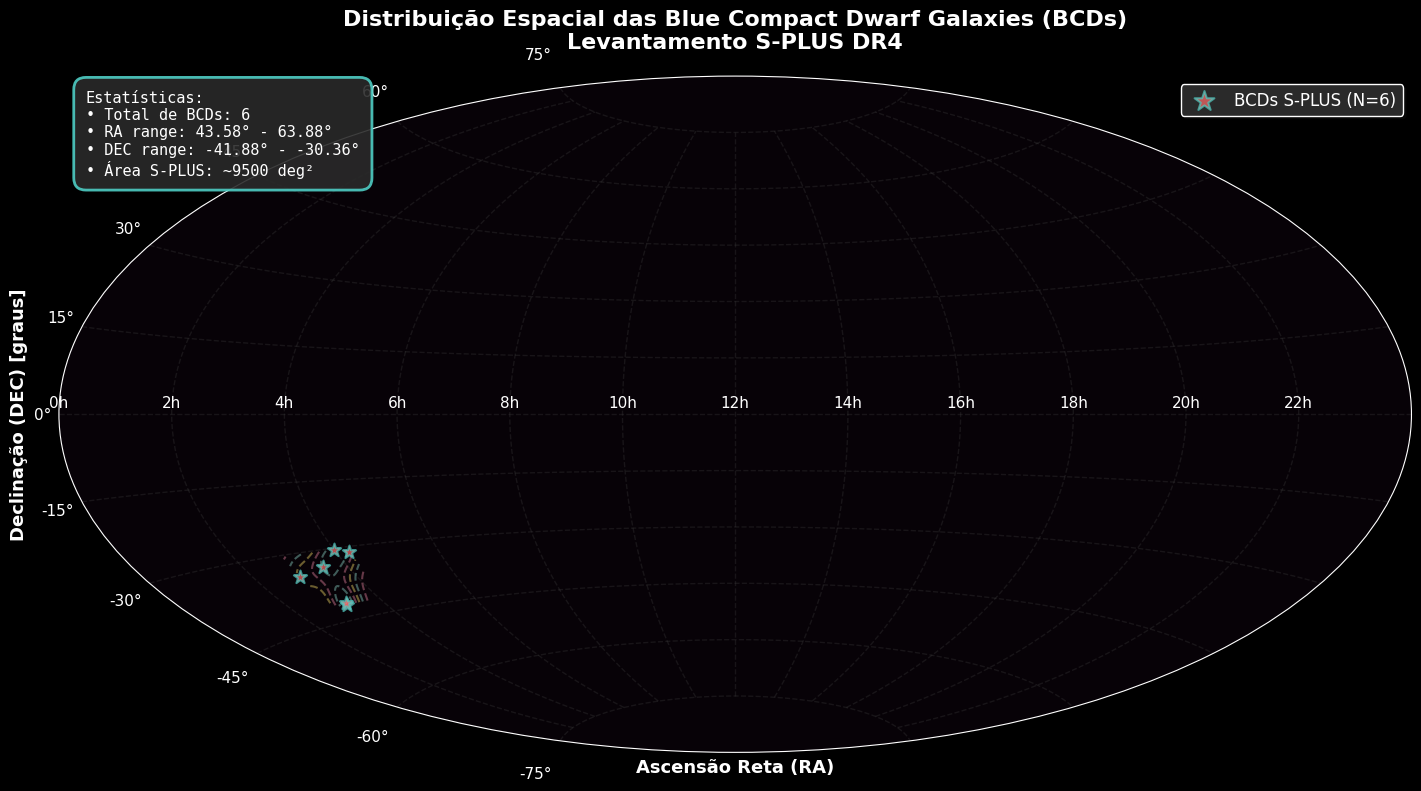

✓ Histogramas salvos: ./imagens/BCDs_histogramas_posicao.png


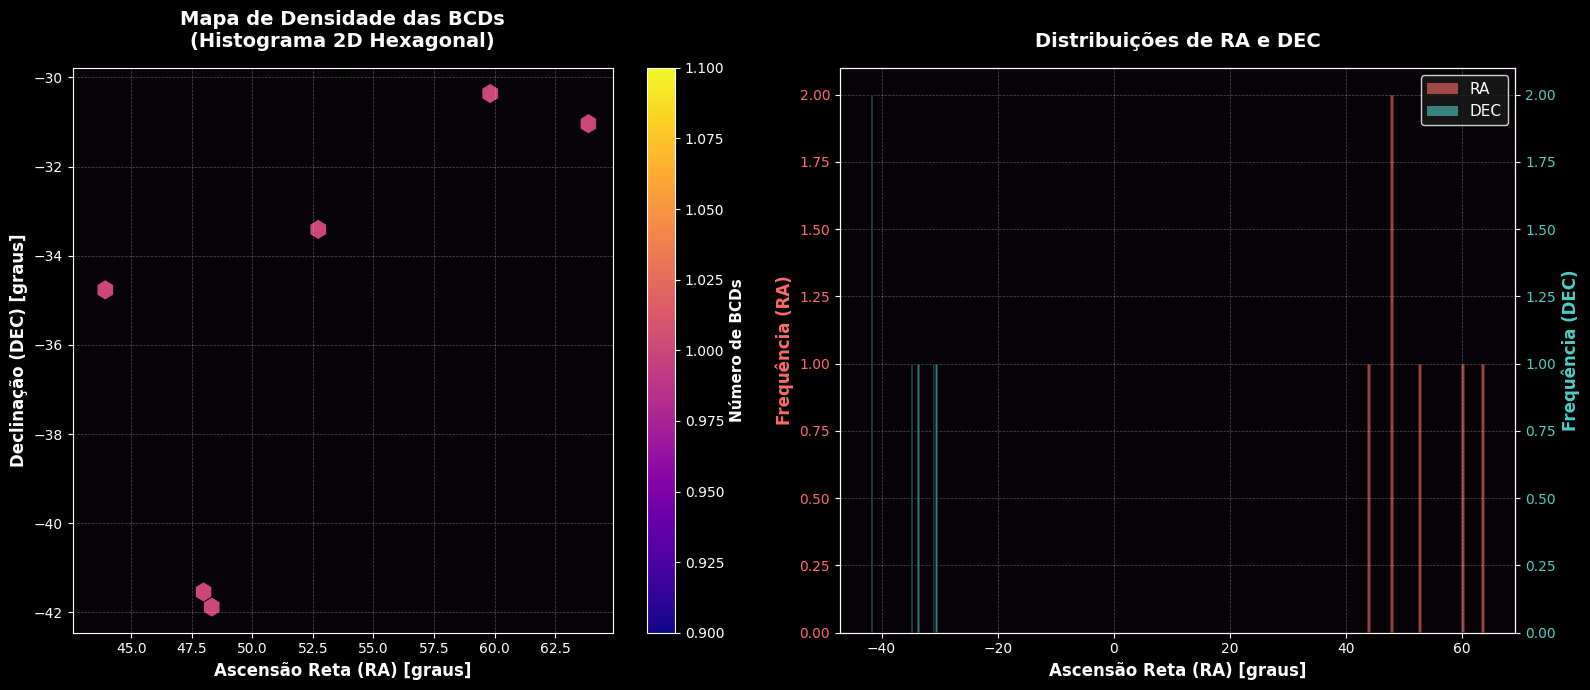


VISUALIZAÇÕES CRIADAS COM SUCESSO!
Total de BCDs no S-PLUS DR4: 6
Cobertura em RA:  43.58° até 63.88°
Cobertura em DEC: -41.88° até -30.36°


In [136]:
from scipy.stats import gaussian_kde
from matplotlib.patches import Patch

# Criar visualização bonita da distribuição RA e DEC das BCDs no céu

fig = plt.figure(figsize=(16, 8))

# Usar projeção de Aitoff (projeção esférica comum em astronomia)
ax = fig.add_subplot(111, projection='aitoff')

# Converter RA e DEC para radianos (necessário para projeção Aitoff)
# RA: 0-360° → -180 a +180° → radianos
# DEC: -90 a +90° → radianos
ra_rad = np.deg2rad(BCDs_splus['RA'] - 180)  # Centralizar em 0
dec_rad = np.deg2rad(BCDs_splus['DEC'])

# Definir cores baseadas no dark_mode
if dark_mode:
    scatter_color = '#FF6B6B'  # Coral vibrante
    edge_color = '#4ECDC4'     # Turquesa
    grid_color = '#404040'     # Cinza médio
    text_color = '#FFFFFF'     # Branco
    background_color = '#1A1A1A'  # Fundo escuro
else:
    scatter_color = 'red'
    edge_color = 'blue'
    grid_color = '#CCCCCC'
    text_color = 'black'
    background_color = 'white'  # Fundo branco

# Plotar as galáxias BCDs
scatter = ax.scatter(ra_rad, dec_rad, 
                    c=scatter_color, 
                    s=100, 
                    alpha=0.7,
                    edgecolors=edge_color, 
                    linewidths=1.5,
                    marker='*',
                    label=f'BCDs S-PLUS (N={len(BCDs_splus)})',
                    zorder=5)

# Configurar a grade
ax.grid(True, alpha=0.3, linestyle='--', color=grid_color, linewidth=1)

# Títulos e labels
ax.set_title('Distribuição Espacial das Blue Compact Dwarf Galaxies (BCDs)\n' + 
             'Levantamento S-PLUS DR4',
             fontsize=16, fontweight='bold', pad=20, color=text_color)

# Labels customizados para RA (em horas)
# Criar labels de RA em formato hh:mm (horas e minutos)
ra_labels = []
for ra_deg in [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]:
    hours = ra_deg / 15  # Converter graus para horas
    ra_labels.append(f'{int(hours)}h')

# Configurar ticks personalizados
tick_labels_ra = np.deg2rad(np.array([0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]) - 180)
ax.set_xticks(tick_labels_ra)
ax.set_xticklabels(ra_labels, fontsize=11, color=text_color)

# Labels para DEC (em graus)
ax.set_xlabel('Ascensão Reta (RA)', fontsize=13, fontweight='bold', color=text_color)
ax.set_ylabel('Declinação (DEC) [graus]', fontsize=13, fontweight='bold', color=text_color)

# Ajustar cor dos ticks de DEC
ax.tick_params(axis='y', labelsize=11, colors=text_color)

# Adicionar legenda
legend = ax.legend(loc='upper right', fontsize=12, frameon=True, 
                  fancybox=True, shadow=True, markerscale=1.5)
if dark_mode:
    legend.get_frame().set_facecolor('#2A2A2A')
    legend.get_frame().set_edgecolor(text_color)
    for text in legend.get_texts():
        text.set_color(text_color)

# Adicionar informações estatísticas
info_text = f"""Estatísticas:
• Total de BCDs: {len(BCDs_splus)}
• RA range: {BCDs_splus['RA'].min():.2f}° - {BCDs_splus['RA'].max():.2f}°
• DEC range: {BCDs_splus['DEC'].min():.2f}° - {BCDs_splus['DEC'].max():.2f}°
• Área S-PLUS: ~9500 deg²"""

if dark_mode:
    box_props = dict(boxstyle='round,pad=0.8', facecolor='#2A2A2A', 
                    edgecolor=edge_color, alpha=0.9, linewidth=2)
else:
    box_props = dict(boxstyle='round,pad=0.8', facecolor='lightblue', 
                    edgecolor='blue', alpha=0.9, linewidth=2)

ax.text(0.02, 0.98, info_text, transform=ax.transAxes,
        fontsize=11, verticalalignment='top',
        bbox=box_props, color=text_color, family='monospace')

# Adicionar marcador de densidade (colorbar baseado em densidade local)
# Calcular densidade local usando KDE

# Criar grid para densidade
ra_grid = np.linspace(ra_rad.min(), ra_rad.max(), 100)
dec_grid = np.linspace(dec_rad.min(), dec_rad.max(), 100)
RA_grid, DEC_grid = np.meshgrid(ra_grid, dec_grid)

# Calcular KDE
positions = np.vstack([RA_grid.ravel(), DEC_grid.ravel()])
values = np.vstack([ra_rad, dec_rad])
kernel = gaussian_kde(values)
density = np.reshape(kernel(positions).T, RA_grid.shape)

# Plotar contornos de densidade
if dark_mode:
    contour_colors = ['#FFE66D', '#F38BA8', '#95E1D3']
else:
    contour_colors = ['yellow', 'orange', 'green']

contours = ax.contour(RA_grid, DEC_grid, density, 
                     levels=5, alpha=0.4, 
                     colors=contour_colors, 
                     linewidths=1.5, linestyles='dashed')

plt.tight_layout()

# Salvar figura
output_fig_sky = f"{output_dir_images}BCDs_distribuicao_ceu.png"
plt.savefig(output_fig_sky, dpi=300, bbox_inches='tight',
           facecolor=background_color)
print(f"✓ Mapa celeste salvo: {output_fig_sky}")

plt.show()

# Criar segunda visualização: Histogramas 2D (densidade)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Histograma 2D de RA vs DEC
h = ax1.hexbin(BCDs_splus['RA'], BCDs_splus['DEC'], 
              gridsize=30, cmap='YlOrRd' if not dark_mode else 'plasma',
              mincnt=1, edgecolors='black', linewidths=0.5)

ax1.set_xlabel('Ascensão Reta (RA) [graus]', fontsize=12, fontweight='bold')
ax1.set_ylabel('Declinação (DEC) [graus]', fontsize=12, fontweight='bold')
ax1.set_title('Mapa de Densidade das BCDs\n(Histograma 2D Hexagonal)', 
             fontsize=14, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.3, linestyle='--')

# Colorbar
cbar1 = plt.colorbar(h, ax=ax1)
cbar1.set_label('Número de BCDs', fontsize=11, fontweight='bold')

# Histogramas separados de RA e DEC
ax2_ra = ax2
ax2_dec = ax2.twinx()

# Histograma de RA
ax2_ra.hist(BCDs_splus['RA'], bins=30, alpha=0.6, 
           color=scatter_color, edgecolor='black', linewidth=1.2,
           label='RA', orientation='vertical')
ax2_ra.set_xlabel('Ascensão Reta (RA) [graus]', fontsize=12, fontweight='bold')
ax2_ra.set_ylabel('Frequência (RA)', fontsize=12, fontweight='bold', 
                 color=scatter_color)
ax2_ra.tick_params(axis='y', labelcolor=scatter_color)

# Histograma de DEC (em overlay)
ax2_dec.hist(BCDs_splus['DEC'], bins=30, alpha=0.6,
            color=edge_color, edgecolor='black', linewidth=1.2,
            label='DEC', orientation='vertical')
ax2_dec.set_ylabel('Frequência (DEC)', fontsize=12, fontweight='bold',
                  color=edge_color)
ax2_dec.tick_params(axis='y', labelcolor=edge_color)

ax2.set_title('Distribuições de RA e DEC', fontsize=14, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3, linestyle='--')

# Legendas customizadas
legend_elements = [Patch(facecolor=scatter_color, alpha=0.6, label='RA'),
                  Patch(facecolor=edge_color, alpha=0.6, label='DEC')]
ax2.legend(handles=legend_elements, loc='upper right', fontsize=11)

plt.tight_layout()

# Salvar
output_fig_hist = f"{output_dir_images}BCDs_histogramas_posicao.png"
plt.savefig(output_fig_hist, dpi=300, bbox_inches='tight',
           facecolor=background_color)
print(f"✓ Histogramas salvos: {output_fig_hist}")

plt.show()

print("\n" + "="*70)
print("VISUALIZAÇÕES CRIADAS COM SUCESSO!")
print("="*70)
print(f"Total de BCDs no S-PLUS DR4: {len(BCDs_splus)}")
print(f"Cobertura em RA:  {BCDs_splus['RA'].min():.2f}° até {BCDs_splus['RA'].max():.2f}°")
print(f"Cobertura em DEC: {BCDs_splus['DEC'].min():.2f}° até {BCDs_splus['DEC'].max():.2f}°")
print("="*70)

# BCDs spectra

In [137]:
# Paths specs & var/errors
base_path = [fr"/home/pierre/pierre/Documents/Faculdade_iag/main_doc/Dados/Reducao_espectros/Proposal_compact_halpha_candidates/espectros_1D_reduzidos/specs_correct/Candidate{i}_corrected.csv" for i in range(1, 2)]

caminho_spec_var = [f"/home/pierre/pierre/Documents/Faculdade_iag/main_doc/Dados/Reducao_espectros/Proposal_compact_halpha_candidates/espectros_1D_reduzidos/vars_correct/Candidate{i}_var_corrected.csv" for i in range(1, 2)]

#___________________________________________________________________________________

df_specs = pd.read_csv(base_path[0], sep='\t')

df_spec_var = pd.read_csv(caminho_spec_var[0], sep='\t')

In [ ]:
df_merged = [pd.merge(df_specs[i], df_spec_var[i], on='wavelength', how='inner') for i in range(6)]

for df in df_merged:
    # Criar a coluna 'flag' com valor padrão 0
    df['flag'] = 0
    
    # Identificar condições para a flag = 99 (erro zero, infinito ou NaN)
    error_is_problematic = (df['error'] == 0) | np.isinf(df['error']) | np.isnan(df['error'])
    
    # Atribuir 99 à flag onde as condições são verdadeiras
    df.loc[error_is_problematic, 'flag'] = 99
    
    # Substituir valores 'inf' e '-inf' por 0.0
    df.replace([np.inf, -np.inf], 0.0, inplace=True)
    
    # Preencher quaisquer valores NaN restantes com 0.0
    df.fillna(0.0, inplace=True)

# Selecionar e reordenar as colunas para o formato final
df_final = [df[['wavelength', 'flux', 'error', 'flag']].copy() for df in df_merged]

# Verificação final (opcional, mas recomendada)
print("Verificando se há valores não finitos nos DataFrames finais...")
for i, df in enumerate(df_final):
    if not np.all(np.isfinite(df)):
        print(f"  Aviso: O espectro {i+1} ainda contém valores não finitos!")
    else:
        print(f"  Espectro {i+1}: OK")


In [ ]:
# Salvar os espectros processados em formato .spec para uso no STARLIGHT

output_dir = "./espectros_BCDs/5-Specs_Starlight_input/"

for i, df in enumerate(df_final, start=1):
    # Criar nome do arquivo
    filename = f"{output_dir}{i}_BCD.spec"
    
    # Salvar com formato compatível com STARLIGHT
    # Formato: wavelength flux error flag, colunas separadas por um espaço
    df.to_csv(filename, sep=' ', index=False, header=False)
    
    print(f"Espectro {i} salvo em: {filename}")

In [ ]:
# Salvar os espectros processados em formato .spec para uso no STARLIGHT

output_dir = "./espectros_BCDs/5-Specs_Starlight_input/"

print("Salvando espectros em formato compatível com STARLIGHT...\n")

for i, df in enumerate(df_final, start=1):
    # Criar nome do arquivo
    filename = f"{output_dir}{i}_BCD.spec"
    
    # Abrir o arquivo para escrita manual
    with open(filename, 'w') as f:
        for index, row in df.iterrows():
            # Formato: primeira coluna colada, depois as outras com 1 espaçamento
            line = "{:.7E} {:.7E} {:.7E} {:d}\n".format(
                row['wavelength'],
                row['flux'],
                row['error'],
                int(row['flag'])
            )
            f.write(line)
    
    print(f"Espectro {i} salvo em: {filename}")

print("\nProcesso concluído!")


# FIX to Starlight

In [141]:
# Calcular a distância de luminosidade a partir do redshift
import astropy.units as u
from astropy.cosmology import Planck18 # Usa o modelo cosmológico padrão do Planck 2018

# 1. Defina a lista de redshifts das suas galáxias
meu_redshift = [0.3094, 0.2662, 0.3279, 0.3237, 0.3084, 0.3252]

# 2. Calcule as distâncias de luminosidade para a lista de redshifts
distancias = Planck18.luminosity_distance(meu_redshift)

# 3. Extraia os valores em Megaparsecs (Mpc)
lumdist_para_starlight = distancias.to(u.Mpc).value

# 4. Imprima os resultados para cada galáxia
print("Valores para usar no grid file do STARLIGHT:\n")
for i, z in enumerate(meu_redshift):
    dist_mpc = lumdist_para_starlight[i]
    print(f"Para o redshift (z) = {z:.4f}, a Distância de Luminosidade é: {dist_mpc:.4f} Mpc")

# Opcional: Imprimir as listas completas
print("\n--- Listas completas ---")
print(f"Redshifts (z): {meu_redshift}")
print(f"Distâncias de Luminosidade: {distancias}")
print(f"Valores numéricos (Mpc): {np.round(lumdist_para_starlight, 4)}")

Valores para usar no grid file do STARLIGHT:

Para o redshift (z) = 0.3094, a Distância de Luminosidade é: 1660.5318 Mpc
Para o redshift (z) = 0.2662, a Distância de Luminosidade é: 1397.4135 Mpc
Para o redshift (z) = 0.3279, a Distância de Luminosidade é: 1775.9102 Mpc
Para o redshift (z) = 0.3237, a Distância de Luminosidade é: 1749.5775 Mpc
Para o redshift (z) = 0.3084, a Distância de Luminosidade é: 1654.3404 Mpc
Para o redshift (z) = 0.3252, a Distância de Luminosidade é: 1758.9727 Mpc

--- Listas completas ---
Redshifts (z): [0.3094, 0.2662, 0.3279, 0.3237, 0.3084, 0.3252]
Distâncias de Luminosidade: [1660.53176615 1397.41350122 1775.91016901 1749.57748854 1654.34040908
 1758.97272916] Mpc
Valores numéricos (Mpc): [1660.5318 1397.4135 1775.9102 1749.5775 1654.3404 1758.9727]


# Analise Starlight output

In [ ]:
from starlight_toolkit.output import read_output_file

spesc_starlight = [pd.read_csv(f'./espectros_BCDs/5-Specs_Starlight_input/1_BCD.spec/{i}_BCD.spec', sep='\t', header=None) for i in range(1, 7)]
BCD_antigo_output = [read_output_file(f'/home/pierre/starlight/STARLIGHTv06/output/antigos/{i}_BCD_antigo.out') for i in range(1, 7)]
BCD_new_output = [read_output_file(f'/home/pierre/starlight/STARLIGHTv06/output/new/{i}_BCD_new.out') for i in range(1, 7)]
BCD_new_2_output = [read_output_file(f'/home/pierre/starlight/STARLIGHTv06/output/new_2/{i}_BCD_new.out') for i in range(1, 7)]
BCD_new_errors_output = [read_output_file(f'/home/pierre/starlight/STARLIGHTv06/output/new_errors/{i}_BCD_new_errors.out') for i in range(2, 6)]


## Read Output

/tmp/ipykernel_920456/343008665.py:923: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


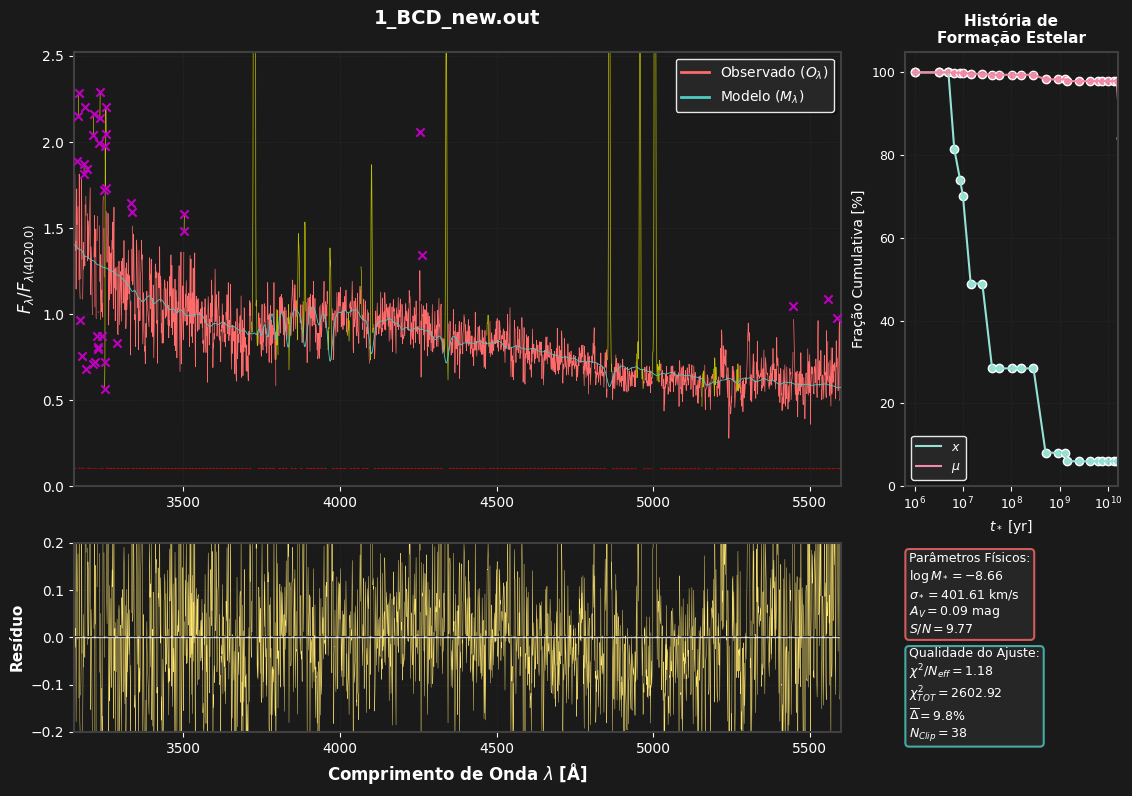

In [ ]:
df_spec_1_starlight = pd.read_csv('./espectros_BCDs/5-Specs_Starlight_input/1_BCD.spec', 
                                   sep=' ', 
                                   header=None, 
                                   names=['wavelength', 'flux', 'error', 'flag'])

df_spec_1_starlight_output = read_output_file('/home/pierre/starlight/STARLIGHTv06/output/new/1_BCD_new.out')

ax_list_1 = plot_fit_complete_dark(df_spec_1_starlight_output, style='dark')
plt.show()

---
## Calcular Contínuo

Comparação entre o espectro observado e o modelo sintético do STARLIGHT.

In [144]:
# Extrair dados do espectro observado e modelo
l_obs = df_spec_1_starlight_output['spectra']['l_obs']
f_obs = df_spec_1_starlight_output['spectra']['f_obs']
f_syn = df_spec_1_starlight_output['spectra']['f_syn']
f_wei = df_spec_1_starlight_output['spectra']['f_wei']

# Máscara para pesos válidos
w0 = f_wei <= 0

# Criar contínuo (espectro observado e modelo sem linhas de emissão)
continuo_obs = np.ma.masked_array(data=f_obs, mask=w0)
continuo_syn = np.ma.masked_array(data=f_syn, mask=w0)

print("="*60)
print("INFORMAÇÕES DO CONTÍNUO")
print("="*60)
print(f"Número de pontos espectrais: {len(l_obs)}")
print(f"Número de pontos válidos: {(~w0).sum()}")
print(f"Número de pontos mascarados: {w0.sum()}")
print(f"Comprimento de onda normalizado: {df_spec_1_starlight_output['keywords']['l_norm']} Å")
print(f"\nIntervalo espectral: {l_obs.min():.1f} - {l_obs.max():.1f} Å")
print(f"Flux observado médio: {continuo_obs.mean():.4f}")
print(f"Flux sintético médio: {continuo_syn.mean():.4f}")
print("="*60)

INFORMAÇÕES DO CONTÍNUO
Número de pontos espectrais: 2451
Número de pontos válidos: 2208
Número de pontos mascarados: 243
Comprimento de onda normalizado: 4020.0 Å

Intervalo espectral: 3150.0 - 5600.0 Å
Flux observado médio: 0.8464
Flux sintético médio: 0.8457


### Comparação Visual do Contínuo

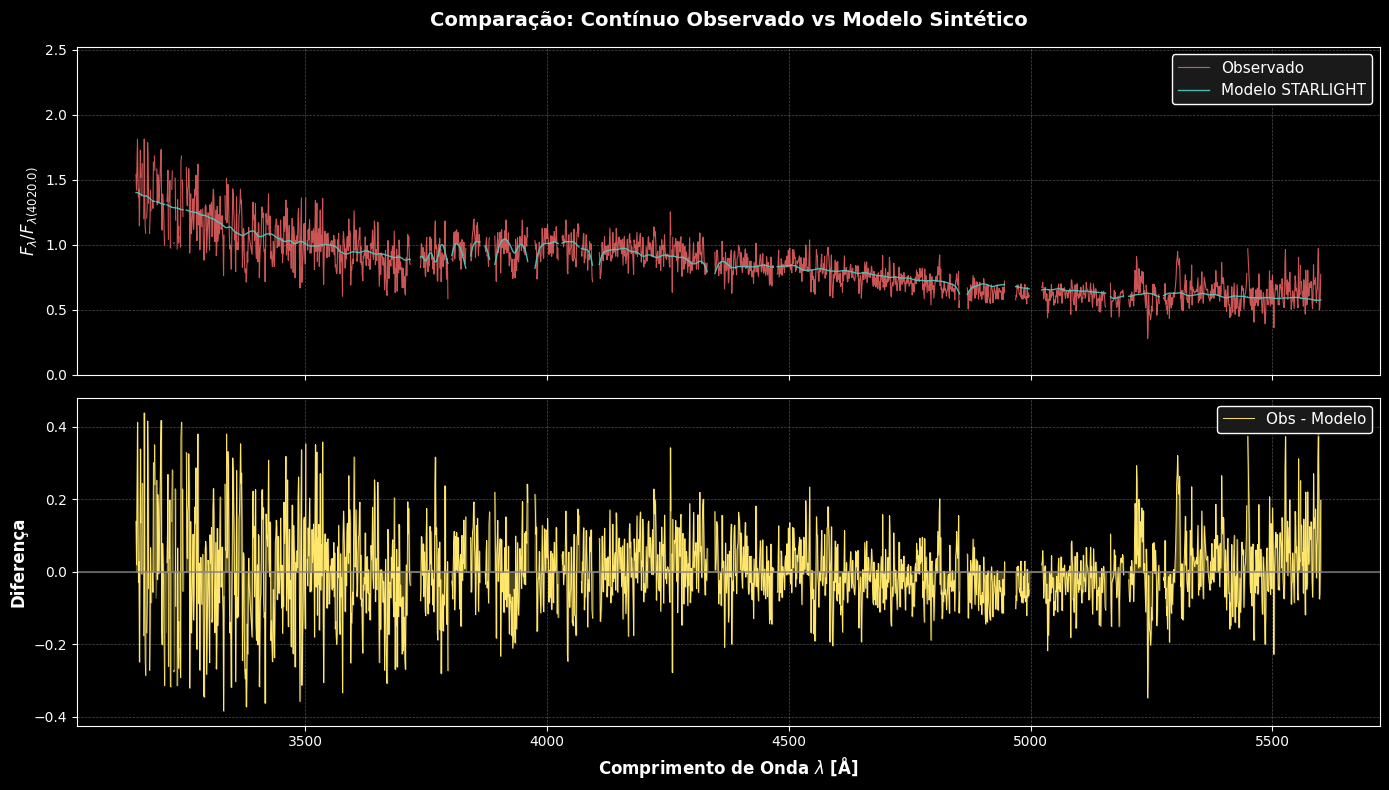

In [145]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

if dark_mode:
    colors_cont = {'obs': '#FF6B6B', 'syn': '#4ECDC4', 'diff': '#FFE66D'}
else:
    colors_cont = {'obs': 'black', 'syn': 'blue', 'diff': 'red'}

# Gráfico 1: Contínuo completo
ax1.plot(l_obs, continuo_obs, color=colors_cont['obs'], lw=0.8, label='Observado', alpha=0.8)
ax1.plot(l_obs, continuo_syn, color=colors_cont['syn'], lw=1.0, label='Modelo STARLIGHT', alpha=0.9)
ax1.set_ylabel(fr'$F_\lambda/F_{{\lambda({df_spec_1_starlight_output["keywords"]["l_norm"]})}}$', fontsize=12, fontweight='bold')
ax1.set_title('Comparação: Contínuo Observado vs Modelo Sintético', fontsize=14, fontweight='bold', pad=15)
ax1.legend(loc='upper right', fontsize=11, frameon=True, fancybox=True, shadow=True)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_ylim(0, 1.8 * np.max(continuo_syn))

# Gráfico 2: Diferença (Obs - Syn)
diferenca = continuo_obs - continuo_syn
ax2.plot(l_obs, diferenca, color=colors_cont['diff'], lw=0.7, label='Obs - Modelo')
ax2.axhline(0, color='gray', linestyle='-', alpha=0.7, linewidth=1.5)
ax2.fill_between(l_obs, 0, diferenca.filled(0), alpha=0.3, color=colors_cont['diff'])
ax2.set_xlabel(r'Comprimento de Onda $\lambda$ [Å]', fontsize=12, fontweight='bold')
ax2.set_ylabel('Diferença', fontsize=12, fontweight='bold')
ax2.legend(loc='upper right', fontsize=11, frameon=True, fancybox=True, shadow=True)
ax2.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

### Zoom em Regiões Específicas do Contínuo

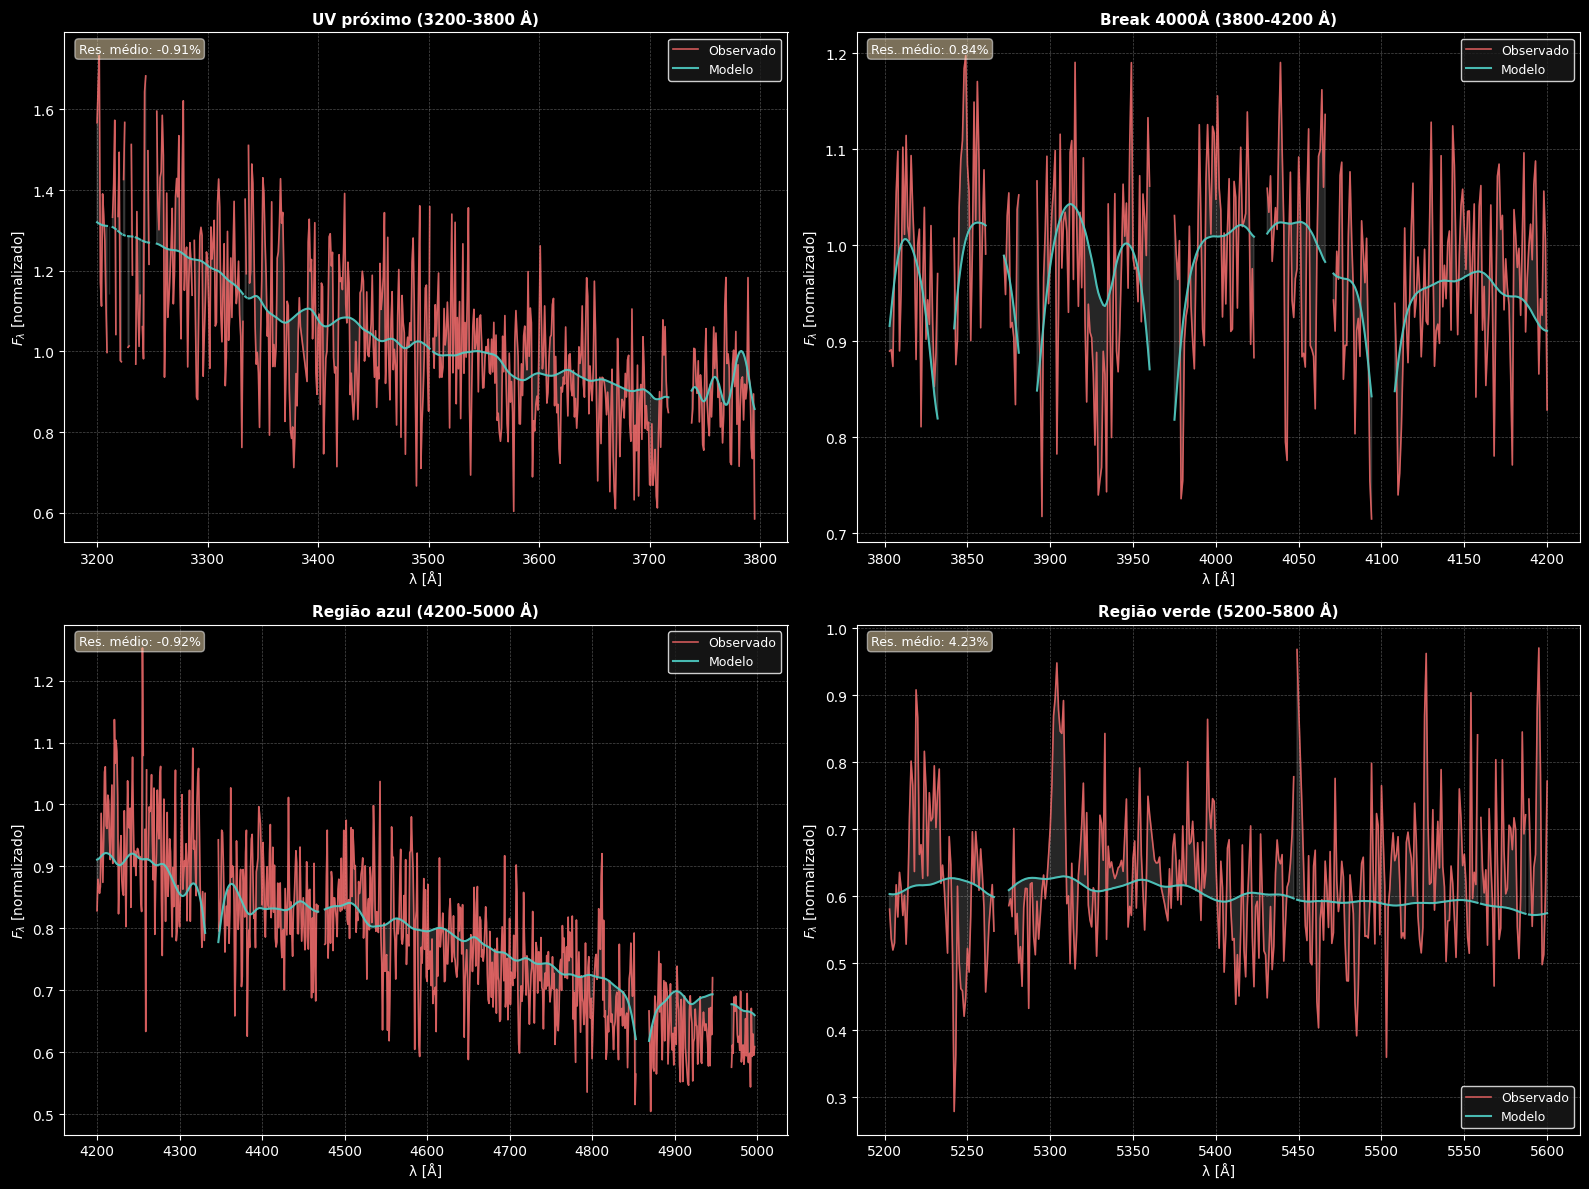

In [146]:
# Criar subplots para zoom em diferentes regiões
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

regioes_zoom = [
    ('UV próximo', 3200, 3800),
    ('Break 4000Å', 3800, 4200),
    ('Região azul', 4200, 5000),
    ('Região verde', 5200, 5800)
]

for idx, (nome, lambda_min, lambda_max) in enumerate(regioes_zoom):
    ax = axes[idx]
    
    # Máscara para a região
    mask_zoom = (l_obs >= lambda_min) & (l_obs <= lambda_max)
    
    # Plot do zoom
    ax.plot(l_obs[mask_zoom], continuo_obs[mask_zoom], 
            color=colors_cont['obs'], lw=1.2, label='Observado', alpha=0.8)
    ax.plot(l_obs[mask_zoom], continuo_syn[mask_zoom], 
            color=colors_cont['syn'], lw=1.5, label='Modelo', alpha=0.9)
    
    # Adicionar sombreamento da diferença
    diferenca_zoom = (continuo_obs - continuo_syn)[mask_zoom]
    ax.fill_between(l_obs[mask_zoom], continuo_syn[mask_zoom], continuo_obs[mask_zoom],
                     alpha=0.3, color='gray')
    
    ax.set_title(f'{nome} ({lambda_min}-{lambda_max} Å)', fontsize=11, fontweight='bold')
    ax.set_xlabel('λ [Å]', fontsize=10)
    ax.set_ylabel(fr'$F_\lambda$ [normalizado]', fontsize=10)
    ax.legend(loc='best', fontsize=9, frameon=True, fancybox=True)
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Calcular e mostrar residual médio nesta região
    if mask_zoom.sum() > 0 and (~w0[mask_zoom]).sum() > 0:
        mask_valido = mask_zoom & (~w0)
        res_medio = np.mean(100 * (f_obs[mask_valido] - f_syn[mask_valido]) / f_syn[mask_valido])
        ax.text(0.02, 0.98, f'Res. médio: {res_medio:.2f}%', 
                transform=ax.transAxes, fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

---
## Espectro Residual para Estudo do Gás

O espectro residual (Obs - Modelo) contém as **linhas de emissão e absorção** que não são explicadas pelo contínuo estelar. Este espectro é essencial para estudar as propriedades do gás ionizado na galáxia.

### Criar e Salvar o Espectro Residual

In [147]:
# Criar espectro residual: Observado - Modelo (contém linhas de emissão/absorção do gás)
# Este é o espectro SEM máscara - contém todas as linhas de emissão e absorção do gás!
espectro_residual = f_obs - f_syn

# Criar DataFrame com o espectro residual (só as 3 colunas essenciais)
df_residual = pd.DataFrame({
    'wavelength': l_obs,
    'flux_obs': f_obs,
    'flux_syn': f_syn,
    'flux_residual': espectro_residual
})

print("="*70)
print("ESPECTRO RESIDUAL CRIADO (Observado - Modelo)")
print("="*70)
print(f"Intervalo espectral: {l_obs.min():.1f} - {l_obs.max():.1f} Å")
print(f"Número total de pontos: {len(df_residual)}")
print(f"\nEstatísticas do Flux Residual (SEM máscara - todos os pontos):")
print(f"  Flux residual médio: {espectro_residual.mean():.6f}")
print(f"  Flux residual std:   {espectro_residual.std():.6f}")
print(f"  Flux residual min:   {espectro_residual.min():.6f}")
print(f"  Flux residual max:   {espectro_residual.max():.6f}")
print("="*70)

# Visualizar primeiras linhas
print("\nPrimeiras linhas do espectro residual:")
print(df_residual.head(10))
print("\n✅ Este espectro contém as linhas de emissão e absorção do gás!")

ESPECTRO RESIDUAL CRIADO (Observado - Modelo)
Intervalo espectral: 3150.0 - 5600.0 Å
Número total de pontos: 2451

Estatísticas do Flux Residual (SEM máscara - todos os pontos):
  Flux residual médio: 0.060309
  Flux residual std:   0.483732
  Flux residual min:   -0.703825
  Flux residual max:   8.361239

Primeiras linhas do espectro residual:
   wavelength  flux_obs  flux_syn  flux_residual
0      3150.0   1.54104   1.40240        0.13864
1      3151.0   1.42077   1.40203        0.01874
2      3152.0   1.61129   1.40149        0.20980
3      3153.0   1.81278   1.40073        0.41205
4      3154.0   1.52959   1.39965        0.12994
5      3155.0   1.36857   1.39821       -0.02964
6      3156.0   1.42374   1.39640        0.02734
7      3157.0   1.14506   1.39426       -0.24920
8      3158.0   1.45165   1.39187        0.05978
9      3159.0   1.72748   1.38933        0.33815

✅ Este espectro contém as linhas de emissão e absorção do gás!


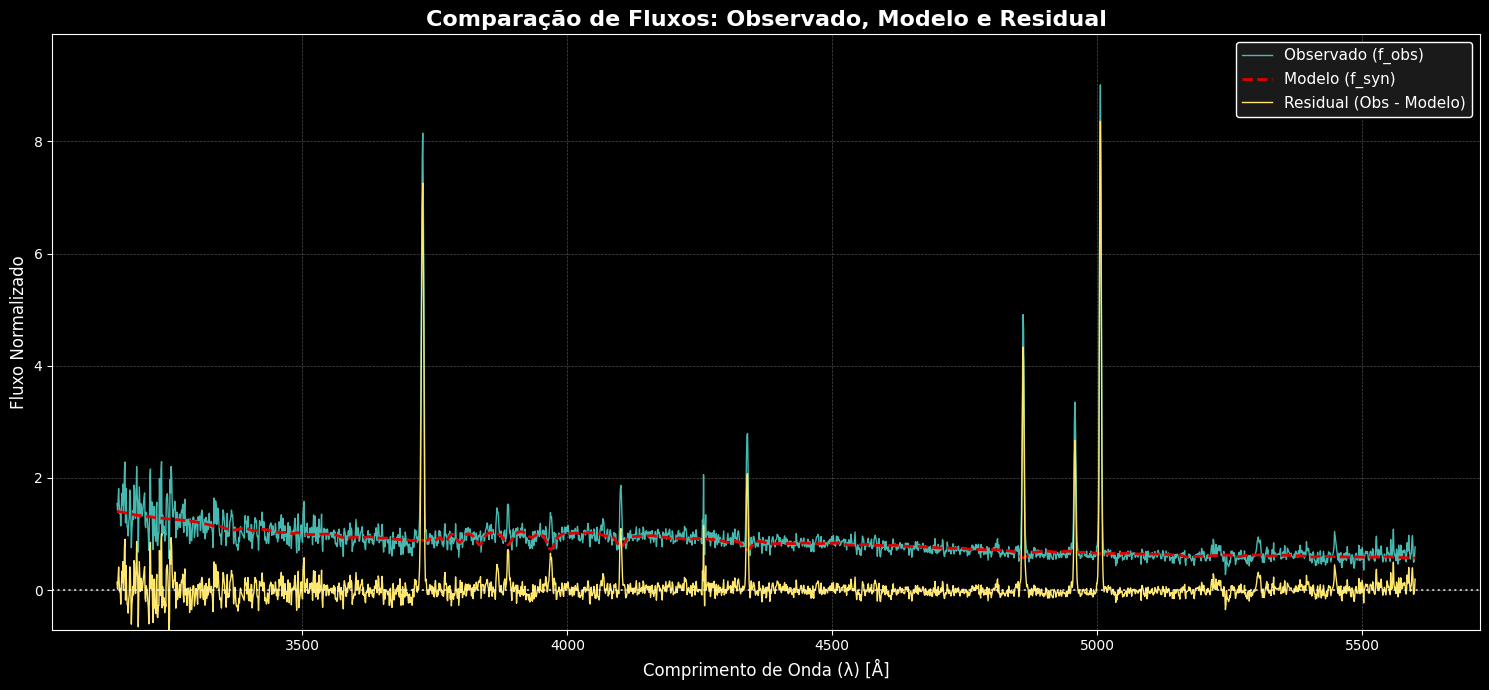

In [148]:
# Criar a figura e os eixos para o plot
fig, ax = plt.subplots(figsize=(15, 7))

# Definir cores com base no dark_mode
if dark_mode:
    color_obs = '#4ECDC4'  # Turquesa para o observado
    color_syn = "#E00000"  # Rosa para o modelo
    color_res = '#FFE66D'  # Amarelo para o residual
    color_zero_line = 'white'
else:
    color_obs = 'blue'
    color_syn = 'red'
    color_res = 'green'
    color_zero_line = 'black'

# Plotar os três espectros no mesmo eixo
ax.plot(l_obs, f_obs, label='Observado (f_obs)', color=color_obs, lw=1.0, alpha=0.9)
ax.plot(l_obs, f_syn, label='Modelo (f_syn)', color=color_syn, lw=2., linestyle='--')
ax.plot(l_obs, espectro_residual, label='Residual (Obs - Modelo)', color=color_res, lw=1.0)

# Adicionar uma linha horizontal em y=0 para referência do residual
ax.axhline(0, color=color_zero_line, linestyle=':', linewidth=1.5, alpha=0.7)

# Configurar títulos e legendas
ax.set_title('Comparação de Fluxos: Observado, Modelo e Residual', fontsize=16, fontweight='bold')
ax.set_xlabel('Comprimento de Onda (λ) [Å]', fontsize=12)
ax.set_ylabel('Fluxo Normalizado', fontsize=12)
ax.legend(fontsize=11, frameon=True, fancybox=True, shadow=True)
ax.grid(True, linestyle='--', alpha=0.3)

# Ajustar limites para melhor visualização
ax.set_ylim(min(espectro_residual.min(), -0.2), f_obs.max() * 1.1)

# Exibir o gráfico
plt.tight_layout()
plt.show()

In [ ]:
# Salvar o espectro residual em diferentes formatos

output_dir = "./espectros_starlight_analise/"

# Salvar como CSV (fácil de ler e processar)
output_csv = f"{output_dir}1_BCD_residual.csv"
df_residual.to_csv(output_csv, index=False)
print(f"✓ Espectro residual salvo em CSV: {output_csv}")

print("\n" + "="*70)
print("ARQUIVOS SALVOS COM SUCESSO!")
print("="*70)
print("Formatos disponíveis:")
print("  • CSV completo: wavelength, flux_obs, flux_syn, flux_residual")
print("  • ASCII simples: 2 colunas (λ, flux_residual)")
print("  • FITS: padrão astronômico, compatível com IRAF/PyRAF")
print("\n🔥 O flux_residual = Obs - Modelo (SEM máscaras)")
print("   Contém TODAS as linhas de emissão e absorção do gás!")
print("="*70)

✓ Espectro residual salvo em CSV: /home/pierre/pierre_work1/Faculdade_teiu/github_teiu/Spectra_pyraf/Projetos/espectros_starlight/1_BCD_residual.csv

ARQUIVOS SALVOS COM SUCESSO!
Formatos disponíveis:
  • CSV completo: wavelength, flux_obs, flux_syn, flux_residual
  • ASCII simples: 2 colunas (λ, flux_residual)
  • FITS: padrão astronômico, compatível com IRAF/PyRAF

🔥 O flux_residual = Obs - Modelo (SEM máscaras)
   Contém TODAS as linhas de emissão e absorção do gás!


### Identificação de Linhas de Emissão Principais

In [150]:
# Dicionário com as principais linhas de emissão nebular (comprimentos de onda no vácuo/ar)
# Ajustar pelo redshift da galáxia se necessário
redshift_galaxy = df_spec_1_starlight_output['keywords'].get('Redshift', 0.0)

linhas_emissao = {
    # Linhas de Balmer
    'Hα': 6562.8,
    'Hβ': 4861.3,
    'Hγ': 4340.5,
    'Hδ': 4101.7,
    'He I 5876': 5875.6,
    
    # Linhas proibidas de oxigênio
    '[O III] 5007': 5006.8,
    '[O III] 4959': 4958.9,
    '[O II] 3727': 3726.0,
    '[O II] 3729': 3728.8,
    '[O I] 6300': 6300.3,
    '[O I] 6364': 6363.8,
    
    # Linhas de nitrogênio
    '[N II] 6548': 6548.0,
    '[N II] 6584': 6583.5,
    '[N I] 5200': 5199.8,
    
    # Linhas de enxofre
    '[S II] 6716': 6716.4,
    '[S II] 6731': 6730.8,
    '[S III] 9069': 9068.6,
    '[S III] 9532': 9531.1,
    
    # Hélio
    'He II 4686': 4685.7,
    'He II 3203': 3203.0,
    'He I 3889': 3888.6,
    
    # Néon e Argônio
    '[Ne III] 3869': 3868.8,
    '[Ne V] 3426': 3425.9,
    '[Ar III] 7135': 7135.8,
    '[Ar IV] 4740': 4740.2,
    
    # Linhas de Paschen (série infravermelha do hidrogênio)
    'Pα': 18751.0,
    'Pβ': 12818.0,
}


# Aplicar redshift se disponível
if redshift_galaxy > 0:
    linhas_emissao_obs = {nome: wl * (1 + redshift_galaxy) 
                          for nome, wl in linhas_emissao.items()}
    print(f"Linhas corrigidas para redshift z = {redshift_galaxy:.4f}")
else:
    linhas_emissao_obs = linhas_emissao
    print("Usando comprimentos de onda de repouso (z = 0)")

# Detectar picos no espectro residual
from scipy.signal import find_peaks

# Encontrar picos no espectro residual (SEM máscara - todos os pontos)
# Usar o espectro residual completo
residual_array = np.array(espectro_residual)

# Parâmetros para detecção de picos (ajustar conforme necessário)
altura_minima = 0.01  # Altura mínima do pico
distancia_minima = 10  # Distância mínima entre picos (em pontos)

picos_idx, propriedades = find_peaks(residual_array, 
                                      height=altura_minima, 
                                      distance=distancia_minima)

picos_wavelength = l_obs[picos_idx]
picos_flux = residual_array[picos_idx]

print(f"\n{'='*70}")
print(f"DETECÇÃO DE LINHAS DE EMISSÃO")
print(f"{'='*70}")
print(f"Número de picos detectados: {len(picos_idx)}")
print(f"Altura mínima: {altura_minima}")
print(f"Distância mínima entre picos: {distancia_minima} pontos")
print(f"{'='*70}\n")

# Identificar linhas detectadas
tolerancia = 10  # Tolerância em Angstroms para identificação

linhas_identificadas = []

# Calcular std do residual para S/N
std_residual_gas = np.std(residual_array)

for wl_pico, flux_pico in zip(picos_wavelength, picos_flux):
    # Procurar linha conhecida próxima
    identificacao = None
    delta_min = float('inf')
    
    for nome_linha, wl_linha in linhas_emissao_obs.items():
        delta = abs(wl_pico - wl_linha)
        if delta < tolerancia and delta < delta_min:
            identificacao = nome_linha
            delta_min = delta
    
    if identificacao:
        linhas_identificadas.append({
            'Nome': identificacao,
            'λ teórico [Å]': linhas_emissao_obs[identificacao],
            'λ observado [Å]': wl_pico,
            'Δλ [Å]': wl_pico - linhas_emissao_obs[identificacao],
            'Flux': flux_pico,
            'S/N (aprox)': flux_pico / std_residual_gas if std_residual_gas > 0 else 0
        })
    else:
        linhas_identificadas.append({
            'Nome': 'Não identificada',
            'λ teórico [Å]': np.nan,
            'λ observado [Å]': wl_pico,
            'Δλ [Å]': np.nan,
            'Flux': flux_pico,
            'S/N (aprox)': flux_pico / std_residual_gas if std_residual_gas > 0 else 0
        })

df_linhas = pd.DataFrame(linhas_identificadas)
df_linhas = df_linhas.sort_values('Flux', ascending=False)

print("LINHAS DE EMISSÃO DETECTADAS:")
print(df_linhas.to_string(index=False))
print(f"\n{'='*70}")

# Salvar tabela de linhas identificadas
output_linhas = f"{output_dir}1_BCD_linhas_emissao.csv"
df_linhas.to_csv(output_linhas, index=False)
print(f"✓ Tabela de linhas salva: {output_linhas}")

Usando comprimentos de onda de repouso (z = 0)

DETECÇÃO DE LINHAS DE EMISSÃO
Número de picos detectados: 166
Altura mínima: 0.01
Distância mínima entre picos: 10 pontos

LINHAS DE EMISSÃO DETECTADAS:
            Nome  λ teórico [Å]  λ observado [Å]  Δλ [Å]     Flux  S/N (aprox)
    [O III] 5007         5006.8           5006.0    -0.8 8.361239    17.284844
     [O II] 3727         3726.0           3727.0     1.0 7.256869    15.001826
              Hβ         4861.3           4860.0    -1.3 4.333270     8.957990
    [O III] 4959         4958.9           4958.0    -0.9 2.672159     5.524044
              Hγ         4340.5           4340.0    -0.5 2.075177     4.289928
Não identificada            NaN           4257.0     NaN 1.148197     2.373620
              Hδ         4101.7           4101.0    -0.7 1.097485     2.268785
Não identificada            NaN           3234.0     NaN 1.008570     2.084975
Não identificada            NaN           3252.0     NaN 0.935640     1.934210
Não ident

### Visualização das Linhas Identificadas

✓ Gráfico salvo: ./imagens/1_BCD_residual_linhas_identificadas.png


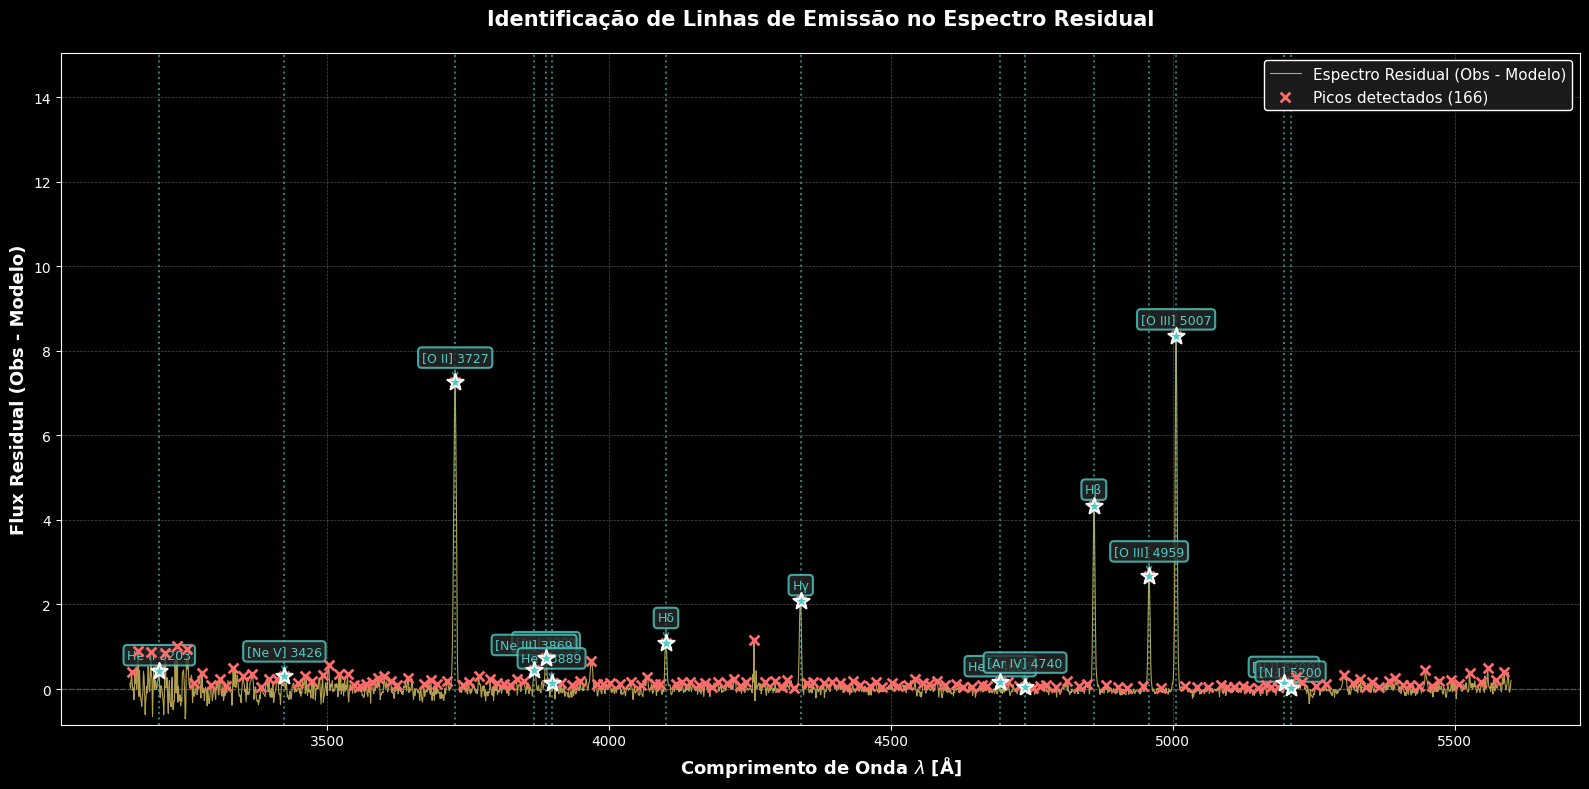


PRINCIPAIS LINHAS IDENTIFICADAS:
         Nome  λ teórico [Å]  λ observado [Å]  Δλ [Å]     Flux  S/N (aprox)
 [O III] 5007         5006.8           5006.0    -0.8 8.361239    17.284844
  [O II] 3727         3726.0           3727.0     1.0 7.256869    15.001826
           Hβ         4861.3           4860.0    -1.3 4.333270     8.957990
 [O III] 4959         4958.9           4958.0    -0.9 2.672159     5.524044
           Hγ         4340.5           4340.0    -0.5 2.075177     4.289928
           Hδ         4101.7           4101.0    -0.7 1.097485     2.268785
    He I 3889         3888.6           3888.0    -0.6 0.724442     1.497609
[Ne III] 3869         3868.8           3867.0    -1.8 0.459130     0.949140
   He II 3203         3203.0           3202.0    -1.0 0.417010     0.862068
  [Ne V] 3426         3425.9           3424.0    -1.9 0.307440     0.635558
   He II 4686         4685.7           4694.0     8.3 0.157194     0.324961
    He I 3889         3888.6           3898.0     9.4 

In [151]:
# Visualização das Linhas de Emissão Identificadas no Espectro Residual

fig, ax = plt.subplots(figsize=(16, 8))

# Definir cores
if dark_mode:
    color_residual = '#FFE66D'  # Amarelo
    color_picos = '#FF6B6B'     # Vermelho/coral
    color_linhas_id = '#4ECDC4' # Turquesa
else:
    color_residual = 'green'
    color_picos = 'red'
    color_linhas_id = 'blue'

# Plotar espectro residual completo
ax.plot(l_obs, espectro_residual, color=color_residual, lw=0.8, 
        label='Espectro Residual (Obs - Modelo)', alpha=0.7)

# Linha de referência em zero
ax.axhline(0, color='gray', linestyle='--', alpha=0.5, linewidth=1)

# Marcar todos os picos detectados
ax.scatter(picos_wavelength, picos_flux, color=color_picos, 
           s=50, marker='x', label=f'Picos detectados ({len(picos_idx)})', 
           zorder=5, linewidths=2)

# Destacar linhas identificadas com anotações
linhas_identificadas_df = df_linhas[df_linhas['Nome'] != 'Não identificada']

for _, linha in linhas_identificadas_df.iterrows():
    wl = linha['λ observado [Å]']
    flux = linha['Flux']
    nome = linha['Nome']
    
    # Linha vertical na posição da linha identificada
    ax.axvline(wl, color=color_linhas_id, linestyle=':', alpha=0.6, linewidth=1.5)
    
    # Marcador especial para linhas identificadas
    ax.scatter(wl, flux, color=color_linhas_id, s=150, marker='*', 
               edgecolors='white', linewidths=1.5, zorder=10)
    
    # Anotação com o nome da linha
    # Alternar posição vertical para evitar sobreposição
    offset = 0.3 if linhas_identificadas_df.index.get_loc(_) % 2 == 0 else 0.5
    
    ax.annotate(nome, 
                xy=(wl, flux), 
                xytext=(wl, flux + offset),
                fontsize=9,
                ha='center',
                color=color_linhas_id,
                bbox=dict(boxstyle='round,pad=0.3', 
                         facecolor='white' if not dark_mode else '#2A2A2A', 
                         edgecolor=color_linhas_id, 
                         alpha=0.8, 
                         linewidth=1.5),
                arrowprops=dict(arrowstyle='->', 
                               color=color_linhas_id, 
                               lw=1.2,
                               alpha=0.7))

# Configurações do plot
ax.set_xlabel(r'Comprimento de Onda $\lambda$ [Å]', fontsize=13, fontweight='bold')
ax.set_ylabel('Flux Residual (Obs - Modelo)', fontsize=13, fontweight='bold')
ax.set_title('Identificação de Linhas de Emissão no Espectro Residual', 
             fontsize=15, fontweight='bold', pad=20)

# Ajustar limites do eixo y para melhor visualização
y_max = max(picos_flux) * 1.8
y_min = min(espectro_residual) * 1.2
ax.set_ylim(y_min, y_max)

# Legenda
ax.legend(loc='upper right', fontsize=11, frameon=True, 
          fancybox=True, shadow=True, ncol=1)

# Grade
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()

# Salvar figura
output_fig = f"{output_dir_images}1_BCD_residual_linhas_identificadas.png"
plt.savefig(output_fig, dpi=300, bbox_inches='tight')
print(f"✓ Gráfico salvo: {output_fig}")

plt.show()

# Criar uma segunda visualização com zoom nas principais linhas
print("\n" + "="*70)
print("PRINCIPAIS LINHAS IDENTIFICADAS:")
print("="*70)
print(linhas_identificadas_df.sort_values('Flux', ascending=False).to_string(index=False))
print("="*70)

### Medição de Fluxos e Razões de Linhas (Diagnóstico Nebular)

In [152]:
# Função para medir fluxo integrado de uma linha
def medir_fluxo_linha(wavelength, flux, lambda_central, largura_integracao=20):
    """
    Mede o fluxo integrado de uma linha de emissão.
    
    Parameters:
    -----------
    wavelength : array
        Comprimentos de onda
    flux : array
        Fluxos
    lambda_central : float
        Comprimento de onda central da linha
    largura_integracao : float
        Largura da janela de integração em Å
    
    Returns:
    --------
    dict com medidas da linha
    """
    # Definir janela de integração
    lambda_min = lambda_central - largura_integracao/2
    lambda_max = lambda_central + largura_integracao/2
    
    # Máscara para a região
    mask = (wavelength >= lambda_min) & (wavelength <= lambda_max)
    
    if mask.sum() < 3:
        return None
    
    wl_regiao = wavelength[mask]
    flux_regiao = flux[mask]
    
    # Estimar contínuo local (média dos extremos)
    n_pontos_continuo = 3
    continuo_esq = np.mean(flux_regiao[:n_pontos_continuo])
    continuo_dir = np.mean(flux_regiao[-n_pontos_continuo:])
    continuo_local = (continuo_esq + continuo_dir) / 2
    
    # Remover contínuo
    flux_linha = flux_regiao - continuo_local
    
    # Integrar usando regra do trapézio
    fluxo_integrado = np.trapz(flux_linha, wl_regiao)
    
    # Pico da linha
    idx_pico = np.argmax(flux_linha)
    lambda_pico = wl_regiao[idx_pico]
    flux_pico = flux_linha[idx_pico]
    
    # Estimar largura equivalente (EW)
    if continuo_local > 0:
        EW = fluxo_integrado / continuo_local
    else:
        EW = np.nan
    
    return {
        'lambda_central': lambda_central,
        'lambda_pico': lambda_pico,
        'flux_integrado': fluxo_integrado,
        'flux_pico': flux_pico,
        'continuo_local': continuo_local,
        'EW': EW,
        'largura_integracao': largura_integracao
    }

# Medir as principais linhas de diagnóstico
linhas_para_medir = {
    'Hα': 6562.8,
    'Hβ': 4861.3,
    '[O III] 5007': 5006.8,
    '[O III] 4959': 4958.9,
    '[N II] 6584': 6583.5,
    '[S II] 6716': 6716.4,
    '[S II] 6731': 6730.8,
    '[O II] 3727': 3726.0,
}

# Aplicar redshift
if redshift_galaxy > 0:
    linhas_para_medir = {nome: wl * (1 + redshift_galaxy) 
                        for nome, wl in linhas_para_medir.items()}

medicoes = {}

print("="*80)
print("MEDIÇÃO DE FLUXOS DAS LINHAS DE EMISSÃO")
print("="*80)
print(f"{'Linha':<20} {'λ central [Å]':<15} {'Fluxo Integrado':<18} {'EW [Å]':<12} {'Flux Pico':<12}")
print("-"*80)

for nome_linha, lambda_central in linhas_para_medir.items():
    medida = medir_fluxo_linha(l_obs, espectro_residual, lambda_central, largura_integracao=25)
    
    if medida is not None:
        medicoes[nome_linha] = medida
        print(f"{nome_linha:<20} {lambda_central:<15.2f} {medida['flux_integrado']:<18.6f} "
              f"{medida['EW']:<12.4f} {medida['flux_pico']:<12.6f}")

print("="*80)

# Calcular razões de linhas importantes para diagnóstico
print("\nRAZÕES DE LINHAS PARA DIAGNÓSTICO NEBULAR:")
print("="*80)

razoes_linhas = {}

# [N II]/Hα - indica metalicidade e grau de ionização
if 'Hα' in medicoes and '[N II] 6584' in medicoes:
    razao_NII_Ha = medicoes['[N II] 6584']['flux_integrado'] / medicoes['Hα']['flux_integrado']
    razoes_linhas['[N II]/Hα'] = razao_NII_Ha
    print(f"[N II] 6584 / Hα = {razao_NII_Ha:.4f}")

# [O III]/Hβ - indica grau de ionização
if 'Hβ' in medicoes and '[O III] 5007' in medicoes:
    razao_OIII_Hb = medicoes['[O III] 5007']['flux_integrado'] / medicoes['Hβ']['flux_integrado']
    razoes_linhas['[O III]/Hβ'] = razao_OIII_Hb
    print(f"[O III] 5007 / Hβ = {razao_OIII_Hb:.4f}")

# [S II] 6716/6731 - indica densidade eletrônica
if '[S II] 6716' in medicoes and '[S II] 6731' in medicoes:
    razao_SII = medicoes['[S II] 6716']['flux_integrado'] / medicoes['[S II] 6731']['flux_integrado']
    razoes_linhas['[S II] 6716/6731'] = razao_SII
    print(f"[S II] 6716 / [S II] 6731 = {razao_SII:.4f}")
    
    # Estimar densidade eletrônica (relação aproximada)
    if 0.4 < razao_SII < 1.4:
        # Fórmula aproximada de Osterbrock & Ferland
        ne = 10**(3.0 + 0.3 * (1.0 - razao_SII))
        print(f"   → Densidade eletrônica estimada: n_e ≈ {ne:.0f} cm⁻³")

# Razão de Balmer Hα/Hβ - indica extinção
if 'Hα' in medicoes and 'Hβ' in medicoes:
    razao_Balmer = medicoes['Hα']['flux_integrado'] / medicoes['Hβ']['flux_integrado']
    razoes_linhas['Hα/Hβ'] = razao_Balmer
    print(f"Hα / Hβ = {razao_Balmer:.4f}")
    
    # Valor teórico (caso B) é ~2.86
    if razao_Balmer > 2.86:
        print(f"   → Razão maior que teórica (2.86): indica avermelhamento por poeira")
        E_BV = 2.5 / 0.61 * np.log10(razao_Balmer / 2.86)
        print(f"   → E(B-V) estimado: {E_BV:.3f} mag")

print("="*80)

# Salvar medições
df_medicoes = pd.DataFrame(medicoes).T
df_medicoes.index.name = 'Linha'
df_medicoes.to_csv(f"{output_dir}1_BCD_medicoes_linhas.csv")
print(f"\n✓ Medições salvas: {output_dir}1_BCD_medicoes_linhas.csv")

# Salvar razões
df_razoes = pd.DataFrame([razoes_linhas])
df_razoes.to_csv(f"{output_dir}1_BCD_razoes_linhas.csv", index=False)
print(f"✓ Razões salvas: {output_dir}1_BCD_razoes_linhas.csv")

MEDIÇÃO DE FLUXOS DAS LINHAS DE EMISSÃO
Linha                λ central [Å]   Fluxo Integrado    EW [Å]       Flux Pico   
--------------------------------------------------------------------------------
Hβ                   4861.30         19.979980          1144.0994    4.315807    
[O III] 5007         5006.80         37.381516          nan          8.388483    
[O III] 4959         4958.90         12.579982          nan          2.714612    
[O II] 3727          3726.00         41.188051          7511.4987    7.251386    

RAZÕES DE LINHAS PARA DIAGNÓSTICO NEBULAR:
[O III] 5007 / Hβ = 1.8709

✓ Medições salvas: /home/pierre/pierre_work1/Faculdade_teiu/github_teiu/Spectra_pyraf/Projetos/espectros_starlight/1_BCD_medicoes_linhas.csv
✓ Razões salvas: /home/pierre/pierre_work1/Faculdade_teiu/github_teiu/Spectra_pyraf/Projetos/espectros_starlight/1_BCD_razoes_linhas.csv


/tmp/ipykernel_920456/968430395.py:44: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  fluxo_integrado = np.trapz(flux_linha, wl_regiao)


### Diagrama BPT (Baldwin-Phillips-Terlevich)

In [153]:
# Diagrama BPT para classificação do tipo de ionização
# Eixo X: log([N II]/Hα)
# Eixo Y: log([O III]/Hβ)

if '[N II]/Hα' in razoes_linhas and '[O III]/Hβ' in razoes_linhas:
    
    x_bpt = np.log10(razoes_linhas['[N II]/Hα'])
    y_bpt = np.log10(razoes_linhas['[O III]/Hβ'])
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Linhas de demarcação (Kewley et al. 2001 e Kauffmann et al. 2003)
    x_line = np.linspace(-2, 0.5, 100)
    
    # Linha de Kewley (limite teórico máximo para SF)
    y_kewley = 0.61 / (x_line - 0.47) + 1.19
    
    # Linha de Kauffmann (divisão empírica SF/AGN)
    y_kauffmann = 0.61 / (x_line - 0.05) + 1.3
    
    # Plot das linhas de demarcação
    ax.plot(x_line, y_kewley, 'k-', lw=2, label='Kewley+01 (limite teórico)')
    mask_kauff = x_line < 0.05
    ax.plot(x_line[mask_kauff], y_kauffmann[mask_kauff], 'k--', lw=2, 
            label='Kauffmann+03 (SF/AGN)')
    
    # Adicionar regiões de classificação
    ax.fill_between(x_line[mask_kauff], -2, y_kauffmann[mask_kauff], 
                     alpha=0.2, color='blue', label='Star-Forming')
    ax.fill_between(x_line, y_kauffmann, y_kewley, 
                     alpha=0.2, color='green', label='Composite', where=(x_line < 0.05))
    ax.fill_between(x_line, y_kewley, 2, 
                     alpha=0.2, color='red', label='AGN')
    
    # Plot do ponto da galáxia
    ax.plot(x_bpt, y_bpt, 'o', markersize=15, color='yellow', 
            markeredgecolor='black', markeredgewidth=2, 
            label='Esta galáxia', zorder=10)
    
    # Adicionar anotação
    ax.annotate(f'([N II]/Hα, [O III]/Hβ)\n({x_bpt:.3f}, {y_bpt:.3f})', 
                xy=(x_bpt, y_bpt), xytext=(x_bpt+0.2, y_bpt+0.2),
                fontsize=10, bbox=dict(boxstyle='round,pad=0.5', 
                facecolor='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', lw=1.5))
    
    # Classificar a galáxia
    if x_bpt < 0.05:
        if y_bpt < y_kauffmann[np.argmin(np.abs(x_line - x_bpt))]:
            classificacao = "STAR-FORMING (SF)"
            cor_class = 'blue'
        elif y_bpt < y_kewley[np.argmin(np.abs(x_line - x_bpt))]:
            classificacao = "COMPOSITE"
            cor_class = 'green'
        else:
            classificacao = "AGN (Seyfert)"
            cor_class = 'red'
    else:
        if y_bpt < y_kewley[np.argmin(np.abs(x_line - x_bpt))]:
            classificacao = "COMPOSITE/LINER"
            cor_class = 'orange'
        else:
            classificacao = "AGN (Seyfert)"
            cor_class = 'red'
    
    ax.text(0.05, 0.95, f'Classificação: {classificacao}', 
            transform=ax.transAxes, fontsize=14, fontweight='bold',
            verticalalignment='top', color=cor_class,
            bbox=dict(boxstyle='round,pad=0.8', facecolor='white', 
                     edgecolor=cor_class, linewidth=3, alpha=0.9))
    
    ax.set_xlabel(r'log([N II] $\lambda$6584 / H$\alpha$)', fontsize=13, fontweight='bold')
    ax.set_ylabel(r'log([O III] $\lambda$5007 / H$\beta$)', fontsize=13, fontweight='bold')
    ax.set_title('Diagrama BPT - Classificação de Ionização', fontsize=15, fontweight='bold', pad=15)
    ax.set_xlim(-2.0, 1.0)
    ax.set_ylim(-1.5, 1.5)
    ax.legend(loc='lower right', fontsize=10, frameon=True, fancybox=True, shadow=True)
    ax.grid(True, alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}1_BCD_diagrama_BPT.png", dpi=300, bbox_inches='tight')
    print(f"✓ Diagrama BPT salvo: {output_dir}1_BCD_diagrama_BPT.png")
    plt.show()
    
    print("\n" + "="*70)
    print(f"CLASSIFICAÇÃO BPT: {classificacao}")
    print("="*70)
    
else:
    print("\n⚠️ Não foi possível criar o diagrama BPT.")
    print("Linhas necessárias: Hα, Hβ, [O III] 5007, [N II] 6584")


⚠️ Não foi possível criar o diagrama BPT.
Linhas necessárias: Hα, Hβ, [O III] 5007, [N II] 6584


# Propriedades do Gás e Formação Estelar

Nesta seção, vamos aprofundar a análise do gás ionizado e das populações estelares, utilizando os fluxos das linhas de emissão (já medidos anteriormente) e os resultados do STARLIGHT.

## 1. Metalicidade e Ionização

Vamos calcular as razões de diagnóstico R23 e O32 para estimar a metalicidade do gás usando os fluxos integrados das linhas de emissão.

### 1.1. Cálculo de R23 e O32

In [154]:
# Linhas necessárias para os índices
linhas_necessarias_R23 = ['[O II] 3727', '[O III] 4959', '[O III] 5007', 'Hβ']
linhas_necessarias_O32 = ['[O III] 5007', '[O II] 3727']

# Verificar se todas as linhas foram medidas
if all(linha in medicoes for linha in linhas_necessarias_R23):
    # Usar os fluxos integrados do dicionário medicoes
    I_OII_3727 = medicoes['[O II] 3727']['flux_integrado']
    I_OIII_4959 = medicoes['[O III] 4959']['flux_integrado']
    I_OIII_5007 = medicoes['[O III] 5007']['flux_integrado']
    I_Hb = medicoes['Hβ']['flux_integrado']
    
    # Calcular R23
    R23 = (I_OII_3727 + I_OIII_4959 + I_OIII_5007) / I_Hb
    log_R23 = np.log10(R23)
    
    print(f"R23 = {R23:.4f}")
    print(f"log(R23) = {log_R23:.4f}")
else:
    R23 = None
    log_R23 = None
    print("⚠️ Não foi possível calcular R23. Linhas necessárias não encontradas.")

if all(linha in medicoes for linha in linhas_necessarias_O32):
    # Usar os fluxos integrados do dicionário medicoes
    I_OIII_5007 = medicoes['[O III] 5007']['flux_integrado']
    I_OII_3727 = medicoes['[O II] 3727']['flux_integrado']
    
    # Calcular O32
    O32 = I_OIII_5007 / I_OII_3727
    log_O32 = np.log10(O32)
    
    print(f"\nO32 = {O32:.4f}")
    print(f"log(O32) = {log_O32:.4f}")
else:
    O32 = None
    log_O32 = None
    print("\n⚠️ Não foi possível calcular O32. Linhas necessárias não encontradas.")

R23 = 4.5620
log(R23) = 0.6592

O32 = 0.9076
log(O32) = -0.0421


### 1.3. Estimativa de Metalicidade com o Calibrador R23

O calibrador R23 é conhecido por ser de valor duplo (*double-valued*), o que significa que uma única razão R23 pode corresponder a duas metalicidades diferentes (um ramo inferior e um ramo superior). Precisamos de um segundo indicador, como [N II]/[O II] ou O32, para desempatar.

- **Ramo Inferior (baixa metalicidade):** Geralmente associado a alto grau de ionização (O32 alto).
- **Ramo Superior (alta metalicidade):** Geralmente associado a baixo grau de ionização (O32 baixo).

In [155]:
# Calibração de McGaugh (1991) para R23
# 12 + log(O/H) = a + b*x + c*x^2 + d*x^3, onde x = log(R23)

def get_metallicity_R23(log_R23, log_O32):
    """
    Estima a metalicidade 12 + log(O/H) usando o calibrador R23 de McGaugh (1991),
    com desempate pelo O32.
    """
    x = log_R23
    
    # Coeficientes para o ramo superior (alta metalicidade)
    a_up, b_up, c_up, d_up = 12.26, -2.445, 1.056, -0.133
    metal_upper = a_up + b_up*x + c_up*x**2 + d_up*x**3
    
    # Coeficientes para o ramo inferior (baixa metalicidade)
    a_low, b_low, c_low, d_low = 3.088, 4.019, -1.090, 0.158
    metal_lower = a_low + b_low*x + c_low*x**2 + d_low*x**3
    
    # Critério de desempate: log(O32)
    # Um valor alto de O32 (> 0.5) geralmente indica o ramo inferior.
    if log_O32 > 0.5:
        ramo = "inferior"
        metalicidade = metal_lower
    else:
        ramo = "superior"
        metalicidade = metal_upper
        
    return metalicidade, ramo, metal_lower, metal_upper

if log_R23 is not None and log_O32 is not None:
    metalicidade_gas, ramo_escolhido, Z_low, Z_up = get_metallicity_R23(log_R23, log_O32)
    
    print("="*70)
    print("ESTIMATIVA DE METALICIDADE (GÁS)")
    print("="*70)
    print(f"log(R23) = {log_R23:.3f}")
    print(f"log(O32) = {log_O32:.3f}")
    print(f"\nCritério de desempate (log(O32) > 0.5) indica o ramo: '{ramo_escolhido}'")
    print(f"\nPossíveis metalicidades:")
    print(f"  • Ramo Inferior: 12 + log(O/H) = {Z_low:.3f}")
    print(f"  • Ramo Superior: 12 + log(O/H) = {Z_up:.3f}")
    print(f"\nMetalicidade do gás estimada: 12 + log(O/H) = {metalicidade_gas:.3f}")
    print("="*70)
else:
    metalicidade_gas = None
    print("Não foi possível estimar a metalicidade do gás.")

ESTIMATIVA DE METALICIDADE (GÁS)
log(R23) = 0.659
log(O32) = -0.042

Critério de desempate (log(O32) > 0.5) indica o ramo: 'superior'

Possíveis metalicidades:
  • Ramo Inferior: 12 + log(O/H) = 5.309
  • Ramo Superior: 12 + log(O/H) = 11.069

Metalicidade do gás estimada: 12 + log(O/H) = 11.069


## 2. Taxa de Formação Estelar (SFR)

A taxa de formação estelar pode ser estimada a partir da luminosidade da linha de Hα, que é diretamente proporcional ao fluxo de fótons ionizantes emitidos por estrelas jovens e massivas.

In [156]:
# Fórmula de Kennicutt (1998) para SFR
# SFR (M_sun/yr) = 7.9e-42 * L(Hα) (erg/s)

# Passo 1: Usar o fluxo de Hα medido anteriormente
if 'Hα' in medicoes:
    # Fluxo de Hα integrado (do dicionário medicoes)
    fluxo_Ha = medicoes['Hα']['flux_integrado']
    
    # Passo 2: Obter a distância da galáxia
    # Usando o redshift e a cosmologia Planck18
    if redshift_galaxy > 0:
        distancia = Planck18.luminosity_distance(redshift_galaxy)
        distancia_cm = distancia.to(u.cm).value
        print(f"Distância da galáxia (z={redshift_galaxy:.4f}): {distancia:.2f}")
    else:
        # Se z=0, assumir uma distância para exemplo (e.g., 10 Mpc)
        distancia = 10 * u.Mpc
        distancia_cm = distancia.to(u.cm).value
        print(f"⚠️ Redshift é zero. Assumindo uma distância de {distancia} para exemplo.")

    # Passo 3: Calcular a luminosidade L(Hα)
    # L = 4 * pi * D^2 * F
    L_Ha = 4 * np.pi * (distancia_cm**2) * fluxo_Ha
    print(f"Luminosidade de Hα: {L_Ha:.4e} erg/s")
    
    # Passo 4: Calcular a SFR
    SFR_Ha = 7.9e-42 * L_Ha
    
    print("\n" + "="*50)
    print("TAXA DE FORMAÇÃO ESTELAR (SFR)")
    print("="*50)
    print(f"SFR(Hα) = {SFR_Ha:.4f} M_sun / ano")
    print("="*50)
else:
    SFR_Ha = None
    print("⚠️ Não foi possível calcular a SFR. Fluxo de Hα não encontrado.")

⚠️ Não foi possível calcular a SFR. Fluxo de Hα não encontrado.


## 3. Propriedades da População Estelar

Vamos extrair as propriedades da população estelar diretamente do output do STARLIGHT e comparar com os indicadores de linhas de emissão.

In [157]:
# Primeiro, vamos ver quais keywords estão disponíveis
print("KEYWORDS DISPONÍVEIS NO OUTPUT DO STARLIGHT:")
print("="*60)
for key in df_spec_1_starlight_output['keywords'].keys():
    print(f"  {key}: {df_spec_1_starlight_output['keywords'][key]}")
print("="*60)


KEYWORDS DISPONÍVEIS NO OUTPUT DO STARLIGHT:
  file_version: v06r02
  arq_synt: 1_BCD_new.out
  IsELROn: 0
  arq_spec: Candidate1_corrected.spec
  obs_dir: /home/pierre/starlight/STARLIGHTv06/obs_dir/
  arq_base: CBASE.PARSEC.chab.all
  arq_masks: EL_mask.msk
  arq_config: S6.conf
  N_base: 150
  N_exAV_components: 0
  N_exAV: 0
  IsCFlawOn: 0
  a0_CFl: 0.0
  a1_CFl: 0.0
  IsFIRcOn: 0
  IsQHRcOn: 0
  IsPHOcOn: 0
  IsOPTimize_fn_OPT: 1
  ETC_ESM: WbN
  ETC_gamma: 0.0
  Np_FIR: 0
  Np_PHO: 0
  Np_QHR: 0
  red_law_option: CAL
  q_norm: 1.355739
  flux_unit: 1e-17
  l_ini: 3150.0
  l_fin: 5600.0
  dl: 1.0
  dl_cushion: 40.0
  l_norm: 4020.0
  llow_norm: 4010.0
  lupp_norm: 4060.0
  fobs_norm: 2.745391e-36
  Lobs_norm: 2.367835e-13
  LumDistInMpc: 1660.532
  llow_SN: 4020.0
  lupp_SN: 4060.0
  SN_snwin: 9.767
  SN_normwin: 9.954
  SNerr_snwin: 9.767
  SNerr_normwin: 9.954
  idum_orig: -992813947
  NOl_eff: 2246
  Nl_eff: 2208
  Ntot_clipped: 38
  clip_method: NSIGMA
  SNmax_threshold: 50.0


In [158]:
# Agora vamos extrair os valores corretos
# Massa estelar corrigida (total)
if 'Mcor_tot' in df_spec_1_starlight_output['keywords']:
    massa_estelar_total = df_spec_1_starlight_output['keywords']['Mcor_tot']
    log_massa_estelar = np.log10(massa_estelar_total) if massa_estelar_total > 0 else np.nan
else:
    massa_estelar_total = None
    log_massa_estelar = None

# Idades médias (verificar se existem)
idade_media_luz = df_spec_1_starlight_output['keywords'].get('at_flux', None)
idade_media_massa = df_spec_1_starlight_output['keywords'].get('at_mass', None)

# Metalicidades médias (verificar se existem)
metalicidade_media_luz = df_spec_1_starlight_output['keywords'].get('Zt_flux', None)
metalicidade_media_massa = df_spec_1_starlight_output['keywords'].get('Zt_mass', None)

print("\n" + "="*60)
print("PROPRIEDADES DA POPULAÇÃO ESTELAR (do STARLIGHT)")
print("="*60)

if massa_estelar_total is not None:
    print(f"Massa Estelar Total (M*): {massa_estelar_total:.4e} M_sun")
    print(f"log(M* / M_sun): {log_massa_estelar:.4f}")
else:
    print("Massa estelar não disponível")

if idade_media_luz is not None:
    print(f"\nIdade Média (ponderada pela luz):   {idade_media_luz:.4e} anos")
else:
    print("\nIdade média (luz) não disponível")
    
if idade_media_massa is not None:
    print(f"Idade Média (ponderada pela massa):  {idade_media_massa:.4e} anos")
else:
    print("Idade média (massa) não disponível")

if metalicidade_media_luz is not None:
    print(f"\nMetalicidade Média (ponderada pela luz):  {metalicidade_media_luz:.4f}")
else:
    print("\nMetalicidade média (luz) não disponível")
    
if metalicidade_media_massa is not None:
    print(f"Metalicidade Média (ponderada pela massa): {metalicidade_media_massa:.4f}")
else:
    print("Metalicidade média (massa) não disponível")

print("="*60)

# Comparação com a Largura Equivalente de Hβ
if 'Hβ' in medicoes:
    EW_Hb = medicoes['Hβ']['EW']
    print(f"\nLargura Equivalente de Hβ (EW(Hβ)): {EW_Hb:.2f} Å")
    
    if EW_Hb > 50:
        print("  -> EW(Hβ) > 50 Å: Indica uma população estelar muito jovem (< 10 milhões de anos),")
        print("     consistente com uma galáxia Blue Compact Dwarf (BCD) em surto de formação.")
    elif EW_Hb > 10:
        print("  -> 10 < EW(Hβ) < 50 Å: Indica uma população estelar jovem.")
    else:
        print("  -> EW(Hβ) < 10 Å: Indica uma população estelar mais envelhecida.")
else:
    EW_Hb = None
    print("\nNão foi possível calcular a Largura Equivalente de Hβ.")


PROPRIEDADES DA POPULAÇÃO ESTELAR (do STARLIGHT)
Massa Estelar Total (M*): 2.1857e-09 M_sun
log(M* / M_sun): -8.6604

Idade média (luz) não disponível
Idade média (massa) não disponível

Metalicidade média (luz) não disponível
Metalicidade média (massa) não disponível

Largura Equivalente de Hβ (EW(Hβ)): 1144.10 Å
  -> EW(Hβ) > 50 Å: Indica uma população estelar muito jovem (< 10 milhões de anos),
     consistente com uma galáxia Blue Compact Dwarf (BCD) em surto de formação.


## 4. Cinemática do Gás (Turbulência)

A largura das linhas de emissão está relacionada com os movimentos do gás, incluindo rotação, inflows, outflows e turbulência. A dispersão de velocidades (σ) é uma medida dessa turbulência. Podemos estimá-la ajustando uma gaussiana a uma linha de emissão forte e isolada.

CINEMÁTICA DO GÁS (via ajuste de [O III] 5007)
Centro da linha (ajustado): 5005.98 Å
Sigma (largura da linha): 1.71 Å

Dispersão de Velocidades (σ_v): 102.49 km/s


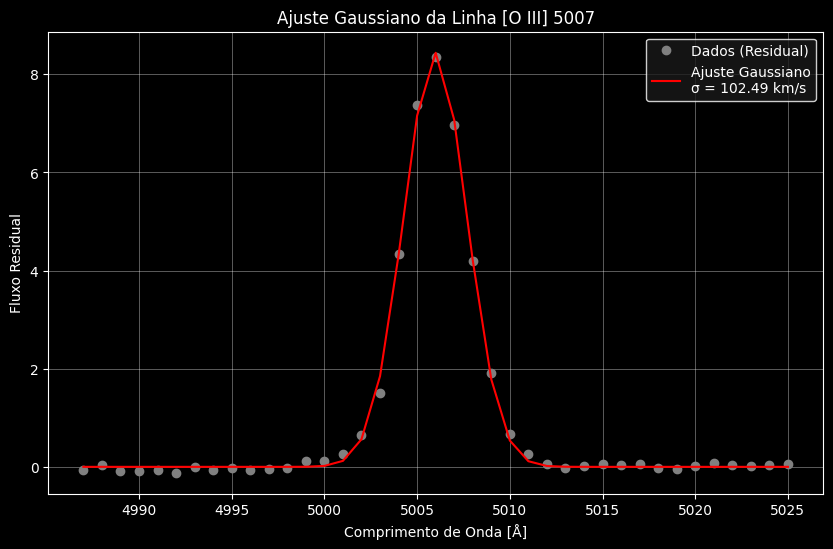

In [159]:
from scipy.optimize import curve_fit

# Função Gaussiana
def gaussiana(x, amplitude, centro, sigma):
    return amplitude * np.exp(-(x - centro)**2 / (2 * sigma**2))

# Escolher uma linha forte e relativamente isolada, como [O III] 5007
linha_para_ajuste = '[O III] 5007'

if linha_para_ajuste in medicoes:
    medida_linha = medicoes[linha_para_ajuste]
    lambda_central = medida_linha['lambda_pico']
    largura_janela = 40  # Å
    
    # Selecionar região ao redor da linha
    mask_ajuste = (l_obs > lambda_central - largura_janela/2) & \
                  (l_obs < lambda_central + largura_janela/2)
    
    wl_regiao = l_obs[mask_ajuste]
    flux_regiao = espectro_residual[mask_ajuste]
    
    # Estimativas iniciais para o ajuste
    amp_inicial = medida_linha['flux_pico']
    centro_inicial = lambda_central
    sigma_inicial = 2.0  # em Å
    
    try:
        # Ajustar a gaussiana
        params, covariance = curve_fit(gaussiana, wl_regiao, flux_regiao, 
                                       p0=[amp_inicial, centro_inicial, sigma_inicial])
        
        amplitude_fit, centro_fit, sigma_fit_A = params
        
        # Converter sigma de Angstroms para km/s
        # σ_v = c * (σ_λ / λ_0)
        c = 299792.458  # km/s
        sigma_vel_kms = c * (sigma_fit_A / centro_fit)
        
        print("="*60)
        print(f"CINEMÁTICA DO GÁS (via ajuste de {linha_para_ajuste})")
        print("="*60)
        print(f"Centro da linha (ajustado): {centro_fit:.2f} Å")
        print(f"Sigma (largura da linha): {sigma_fit_A:.2f} Å")
        print(f"\nDispersão de Velocidades (σ_v): {sigma_vel_kms:.2f} km/s")
        print("="*60)
        
        # Plotar o ajuste
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(wl_regiao, flux_regiao, 'o', label='Dados (Residual)', color='gray')
        ax.plot(wl_regiao, gaussiana(wl_regiao, *params), '-', color='red', 
                label=f'Ajuste Gaussiano\nσ = {sigma_vel_kms:.2f} km/s')
        ax.set_xlabel('Comprimento de Onda [Å]')
        ax.set_ylabel('Fluxo Residual')
        ax.set_title(f'Ajuste Gaussiano da Linha {linha_para_ajuste}')
        ax.legend()
        ax.grid(True, alpha=0.5)
        plt.show()
        
    except RuntimeError:
        print("⚠️ Não foi possível ajustar a gaussiana à linha {linha_para_ajuste}.")
        sigma_vel_kms = None
else:
    sigma_vel_kms = None
    print(f"⚠️ Linha {linha_para_ajuste} não encontrada para análise cinemática.")